## Adaptive Forecast Verification

Code for verification of adaptive forecasts based on hybrid RMSE technique. Verification will be applied to each domain for 12 and 24 hour leadtimes, split by month and all forecasts. Verification will also be considered by domain and month for the analogue leadtime.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from analogue_algorithm import rmse_dask
import dask
from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [2]:
def gaussian_filter_xr(input, sigma):
    return xr.apply_ufunc(gaussian_filter, input, sigma, dask='allowed')

### Jan 2016 Analogue Leadtimes

Verify adaptive forecasts based on the leadtime for analogue selection. 

In [4]:
# Start by parsing adaptive log file
an_log = pd.read_csv('/home/twixtrom/adaptive_WRF/adaptive_WRF/an_selection_log_201601.log', 
                     delimiter=', ', 
                     header=None, 
                     names=['Date', 'Domain', 'Leadtime', 'MP', 'PBL'],
                     usecols=['Date', 'Domain', 'Leadtime']).sort_values('Date', ascending=True)

In [5]:
an_log

,Date,Domain,Leadtime
13,2016010212,d01,24
9,2016010312,d01,24
27,2016010412,d01,24
18,2016010512,d01,24
2,2016010612,None,None
7,2016010712,d01,12
17,2016010812,d01,24
25,2016010912,d01,24
19,2016011012,d01,12
3,2016011112,d01,24


In [81]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = str(row['Domain'])
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
#     elif datestr == '2016011412':
#         print('Skipping 2016011412')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
    elif datestr == '2016011112':
        print('Skipping 2016011112')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
#     elif datestr == '2016011012':
#         print('Skipping 2016011012')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
#     elif datestr == '2016012912':
#         print('Skipping 2016012912')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
    else:
        leadtime = int(row['Leadtime'])
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201601_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201601_01h.nc'
        # open the data files
        adaptive = xr.open_dataset(adp_file)
        thompson = xr.open_dataset(thomp_file)
        ETA = xr.open_dataset(eta_file)
        stage4 = xr.open_dataset(precip_file)
        # Get just the precipitation for the analogue time
        adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
        thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
        ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
        obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

Skipping None data point
Skipping 2016011112
Skipping None data point
Skipping None data point
Skipping None data point
Skipping None data point


In [85]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_jan_adp = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


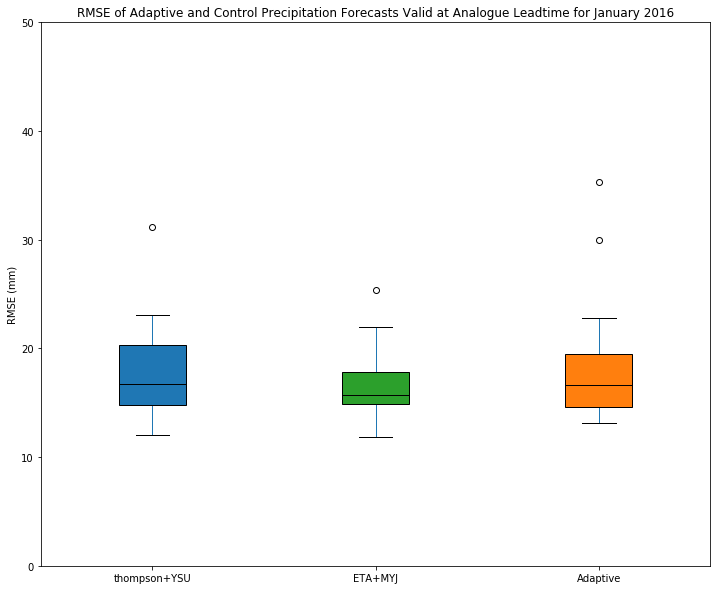

In [132]:
bp = rmse_jan_adp.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Precipitation Forecasts Valid at Analogue Leadtime for January 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

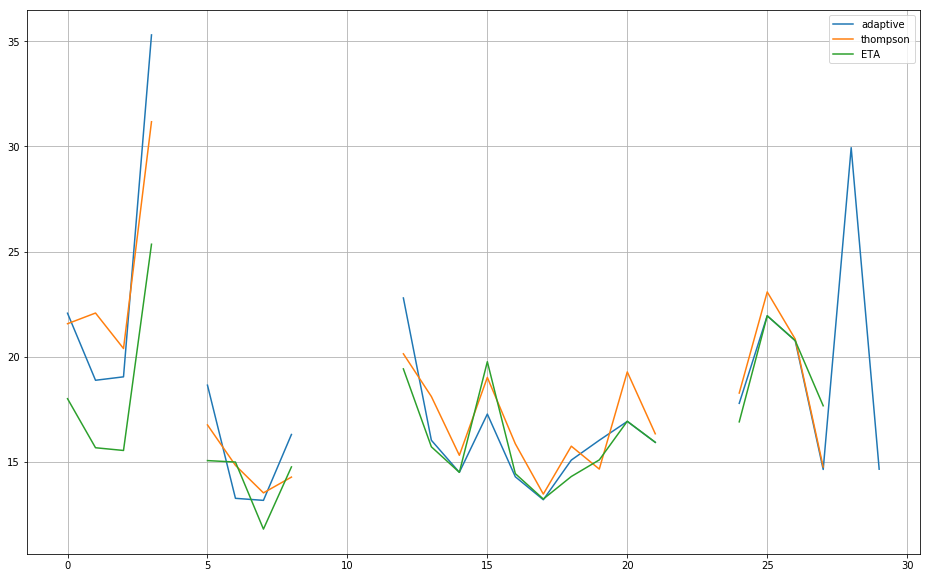

In [9]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.legend()
plt.grid()
plt.show()

In [10]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 18.270449201265972
Mean Thompson RMSE: 17.89066638117251
Mean ETA RMSE: 16.677313887554668


### For a 12-h Leadtime

In [111]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = str(row['Domain'])
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
#     elif datestr == '2016011412':
#         print('Skipping 2016011412')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
    elif datestr == '2016011112':
        print('Skipping 2016011112')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
#     elif datestr == '2016011012':
#         print('Skipping 2016011012')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
#     elif datestr == '2016012912':
#         print('Skipping 2016012912')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
        pass
    else:
        leadtime = 12
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201601_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201601_01h.nc'
        # open the data files
        adaptive = xr.open_dataset(adp_file)
        thompson = xr.open_dataset(thomp_file)
        ETA = xr.open_dataset(eta_file)
        stage4 = xr.open_dataset(precip_file)
        # Get just the precipitation for the analogue time
        adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
        thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
        ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
        obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

Skipping None data point
Skipping 2016011112
Skipping None data point
Skipping None data point
Skipping None data point
Skipping None data point


In [112]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_jan_12 = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


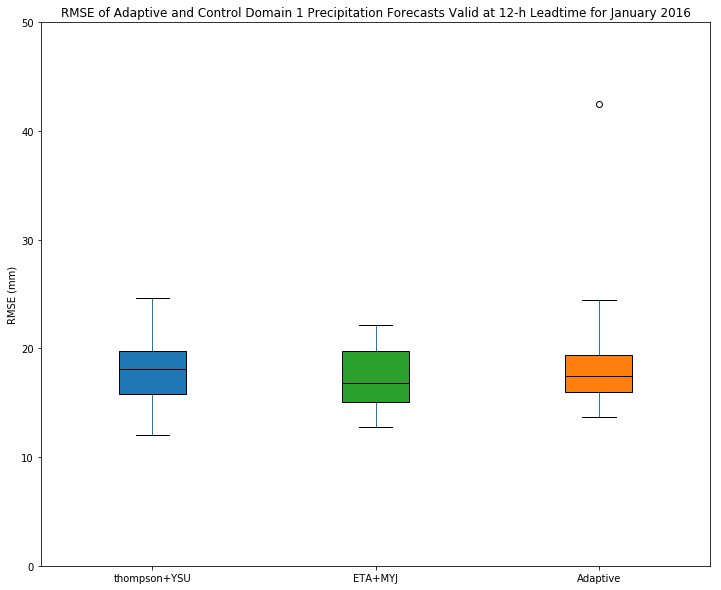

In [130]:
bp = rmse_jan_12.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Domain 1 Precipitation Forecasts Valid at 12-h Leadtime for January 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

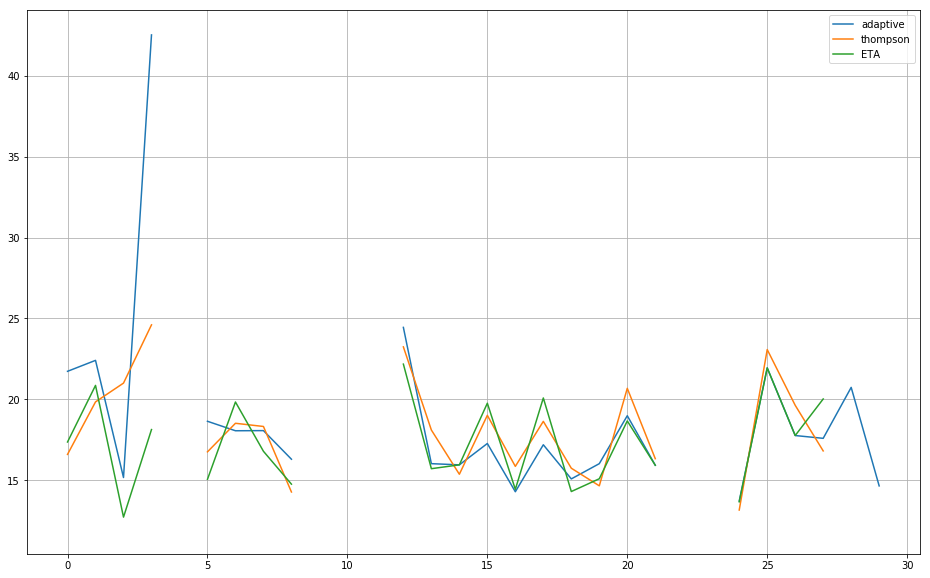

In [13]:
%matplotlib inline
fig = plt.figure(figsize=(16,10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.legend()
plt.grid()
plt.show()

In [14]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 18.77494251728058
Mean Thompson RMSE: 17.92677576645561
Mean ETA RMSE: 17.254705802254055


### For a 24-h Leadtime

In [117]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = str(row['Domain'])
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
#     elif datestr == '2016011412':
#         print('Skipping 2016011412')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
    elif datestr == '2016011112':
        print('Skipping 2016011112')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
#     elif datestr == '2016011012':
#         print('Skipping 2016011012')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
#     elif datestr == '2016012912':
#         print('Skipping 2016012912')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
    else:
        leadtime = 24
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201601_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201601_01h.nc'
        # open the data files
        adaptive = xr.open_dataset(adp_file)
        thompson = xr.open_dataset(thomp_file)
        ETA = xr.open_dataset(eta_file)
        stage4 = xr.open_dataset(precip_file)
        # Get just the precipitation for the analogue time
        adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
        thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
        ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
        obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

Skipping None data point
Skipping 2016011112
Skipping None data point
Skipping None data point
Skipping None data point
Skipping None data point


In [118]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_jan_24 = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s


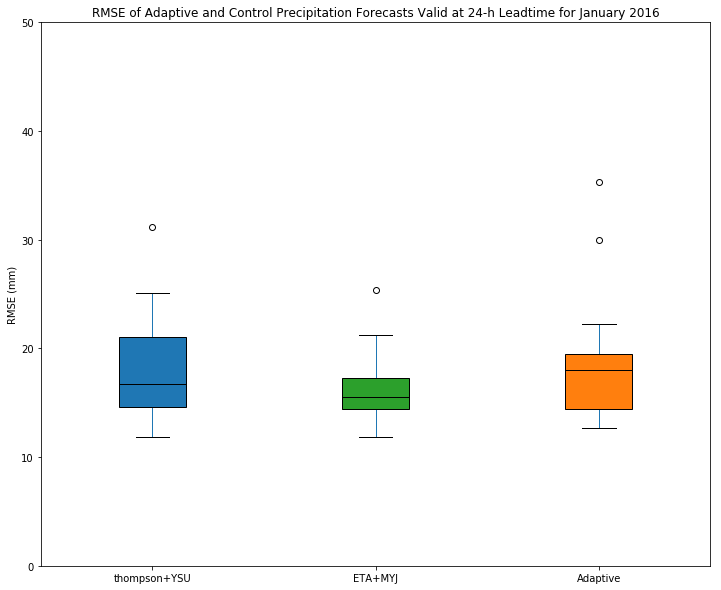

In [127]:
bp = rmse_jan_24.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Precipitation Forecasts Valid at 24-h Leadtime for January 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

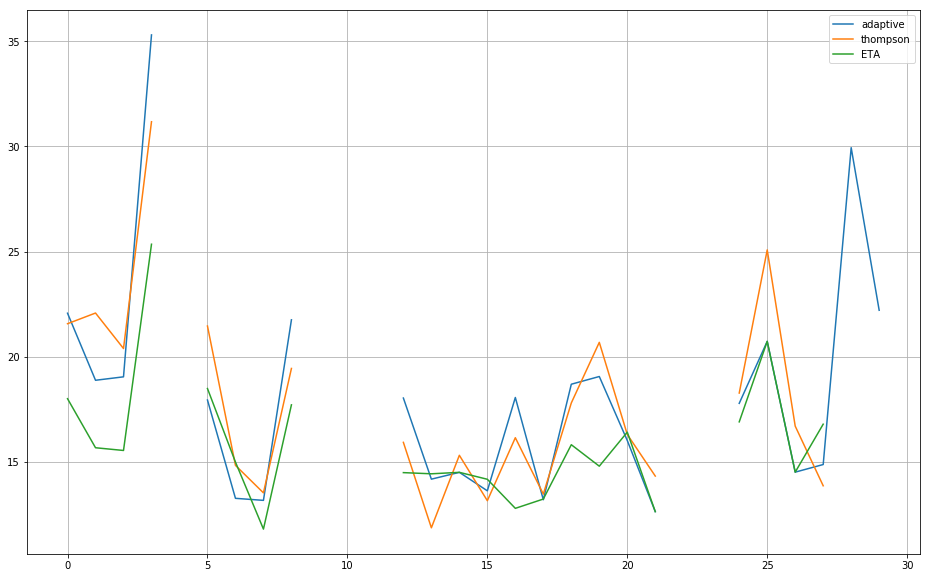

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.grid()
plt.legend()
plt.show()

In [18]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 18.312833786010742
Mean Thompson RMSE: 18.033719062805176
Mean ETA RMSE: 16.13133612923


### For a 36-h Leadtime

In [121]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = str(row['Domain'])
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
#     elif datestr == '2016010412':
#         print('Skipping 2016010412')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
#     elif datestr == '2016011412':
#         print('Skipping 2016011412')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
    elif datestr == '2016011112':
        print('Skipping 2016011112')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
#     elif datestr == '2016011012':
#         print('Skipping 2016011012')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
#     elif datestr == '2016012912':
#         print('Skipping 2016012912')
#         rmse_adaptive.append(np.nan)
#         rmse_thompson.append(np.nan)
#         rmse_eta.append(np.nan)
#         pass
    else:
        leadtime = 36
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201601_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201601_01h.nc'
        # open the data files
        adaptive = xr.open_dataset(adp_file)
        thompson = xr.open_dataset(thomp_file)
        ETA = xr.open_dataset(eta_file)
        stage4 = xr.open_dataset(precip_file)
        # Get just the precipitation for the analogue time
        adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
        thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
        ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
        obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

Skipping None data point
Skipping 2016011112
Skipping None data point
Skipping None data point
Skipping None data point
Skipping None data point


In [122]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_jan_36 = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


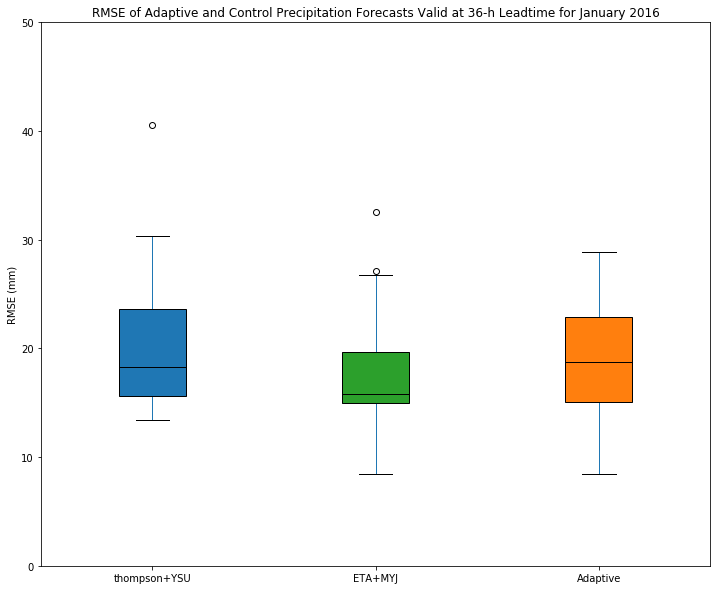

In [129]:
bp = rmse_jan_36.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Precipitation Forecasts Valid at 36-h Leadtime for January 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

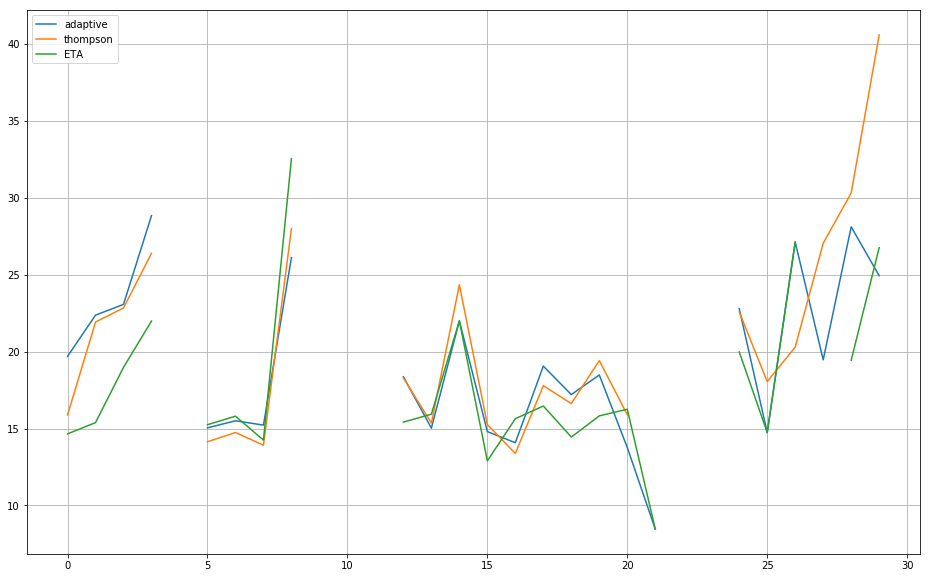

In [21]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.grid()
plt.legend()
plt.show()

In [22]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 19.33822198708852
Mean Thompson RMSE: 20.560161383255668
Mean ETA RMSE: 17.831211587657098


### May 2016 Analogue Leadtimes

Verify adaptive forecasts based on the leadtime for analogue selection. 

In [136]:
# Start by parsing adaptive log file
an_log = pd.read_csv('/home/twixtrom/adaptive_WRF/adaptive_WRF/an_selection_log_201605.log', 
                     delimiter=', ', 
                     header=None, 
                     names=['Date', 'Domain', 'Leadtime', 'MP', 'PBL'],
                     usecols=['Date', 'Domain', 'Leadtime']).sort_values('Date', ascending=True)

In [144]:
an_log

,Date,Domain,Leadtime
10,2016050212,d01,21
24,2016050312,d01,24
15,2016050412,d01,24
11,2016050512,d01,12
7,2016050612,d01,12
25,2016050712,d01,12
16,2016050812,d02,12
21,2016050912,d01,12
0,2016051012,None,None
28,2016051112,d02,17


In [137]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = str(row['Domain'])
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
    else:
        leadtime = int(row['Leadtime'])
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201605_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201605_01h.nc'
        # open the data files
        try:
            adaptive = xr.open_dataset(adp_file)
            thompson = xr.open_dataset(thomp_file)
            ETA = xr.open_dataset(eta_file)
            stage4 = xr.open_dataset(precip_file)
        except FileNotFoundError:
            print('Data not found '+str(date))
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            pass
        # Get just the precipitation for the analogue time
        try:
            adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
            thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
            ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
            obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
        except KeyError:
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            print('Forecast not complete '+str(date))
            pass

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

Skipping None data point
Skipping None data point
Skipping None data point
Skipping None data point
Skipping None data point
Skipping None data point
Skipping None data point


In [145]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_may_adp = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


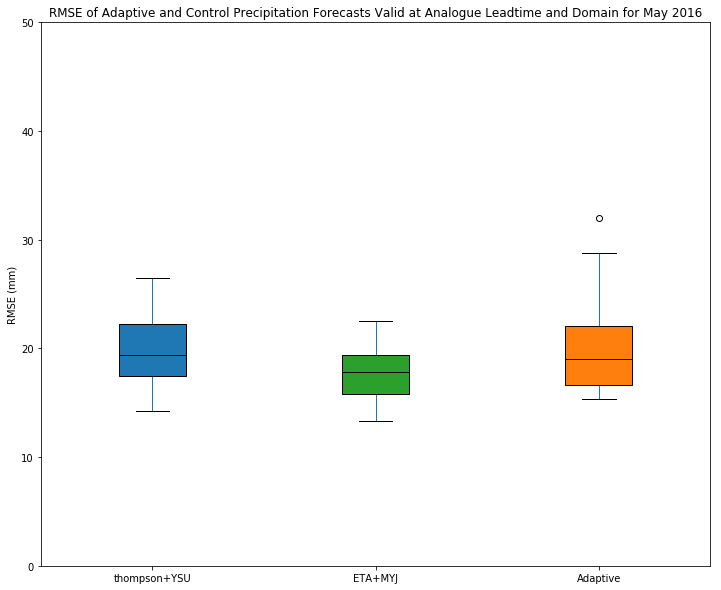

In [153]:
bp = rmse_may_adp.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Precipitation Forecasts Valid at Analogue Leadtime and Domain for May 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

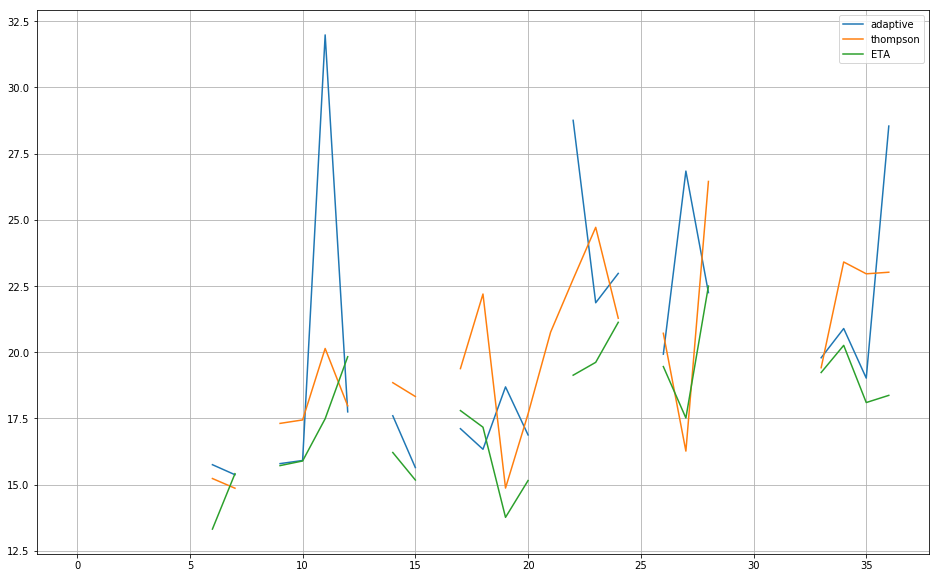

In [147]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.legend()
plt.grid()
plt.show()

In [29]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 21.236196352087934
Mean Thompson RMSE: 20.67905517246412
Mean ETA RMSE: 18.523041932479195


### For a 12-h Leadtime

In [140]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = 'd02'
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
    else:
        domain = 'd02'
        leadtime = 12
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201605_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201605_01h.nc'
        # open the data files
        try:
            adaptive = xr.open_dataset(adp_file)
            thompson = xr.open_dataset(thomp_file)
            ETA = xr.open_dataset(eta_file)
            stage4 = xr.open_dataset(precip_file)
        except FileNotFoundError:
            print('Data not found '+str(date))
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            pass
        # Get just the precipitation for the analogue time
        try:
            adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
            thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
            ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
            obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
        except KeyError:
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            print('Forecast not complete '+str(date))
            pass

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

Data not found 2016-05-10 12:00:00
Data not found 2016-05-14 12:00:00
Data not found 2016-05-16 12:00:00
Data not found 2016-05-24 12:00:00
Data not found 2016-05-27 12:00:00
Data not found 2016-05-28 12:00:00
Forecast not complete 2016-05-28 12:00:00


In [148]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_may_12 = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


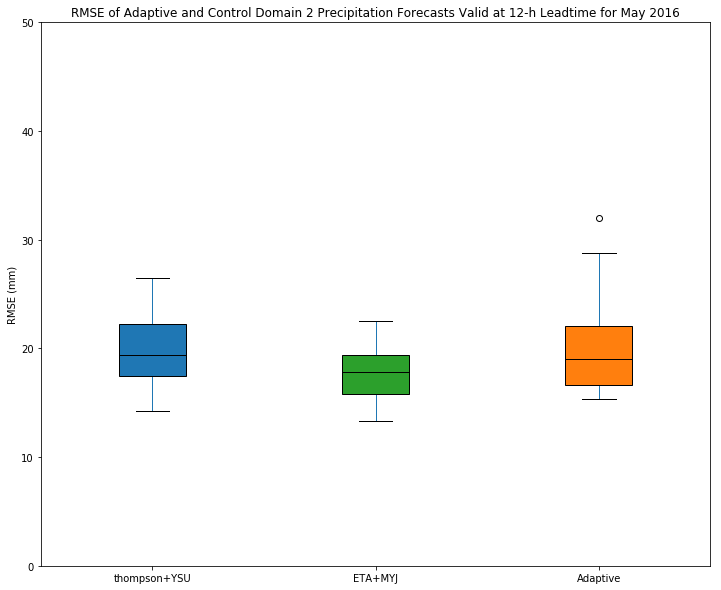

In [152]:
bp = rmse_may_12.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Domain 2 Precipitation Forecasts Valid at 12-h Leadtime for May 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

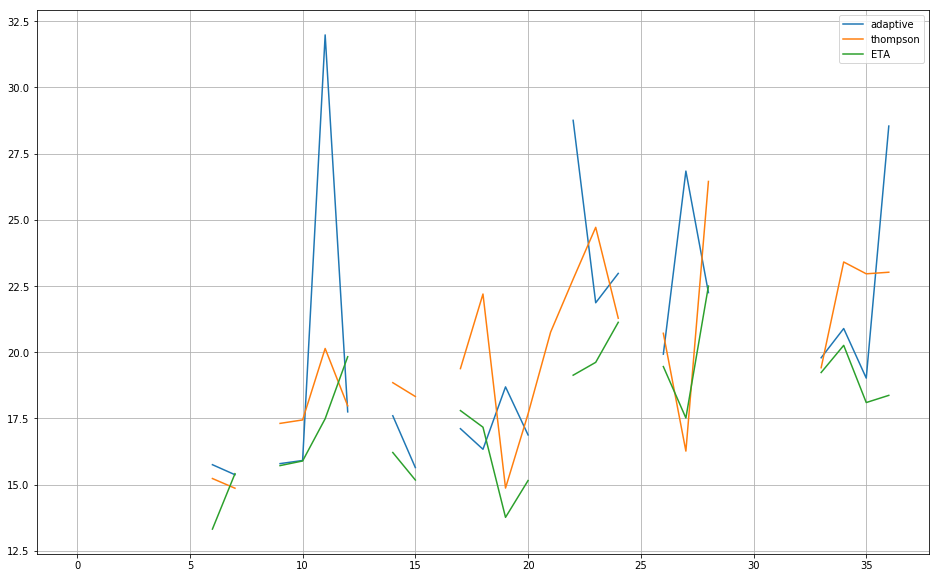

In [150]:
%matplotlib inline
fig = plt.figure(figsize=(16,10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.legend()
plt.grid()
plt.show()

In [151]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 20.23872823300569
Mean Thompson RMSE: 19.586902847290037
Mean ETA RMSE: 17.717616122701894


### For a 24-h Leadtime

In [154]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = 'd02'
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
    else:
        domain = 'd02'
        leadtime = 24
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201605_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201605_01h.nc'
        # open the data files
        try:
            adaptive = xr.open_dataset(adp_file)
            thompson = xr.open_dataset(thomp_file)
            ETA = xr.open_dataset(eta_file)
            stage4 = xr.open_dataset(precip_file)
        except FileNotFoundError:
            print('Data not found '+str(date))
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            pass
        # Get just the precipitation for the analogue time
        try:
            adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
            thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
            ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
            obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
        except KeyError:
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            print('Forecast not complete '+str(date))
            pass

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

Data not found 2016-05-10 12:00:00
Data not found 2016-05-14 12:00:00
Data not found 2016-05-16 12:00:00
Data not found 2016-05-24 12:00:00
Data not found 2016-05-27 12:00:00
Data not found 2016-05-28 12:00:00
Forecast not complete 2016-05-28 12:00:00


In [155]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_may_24 = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


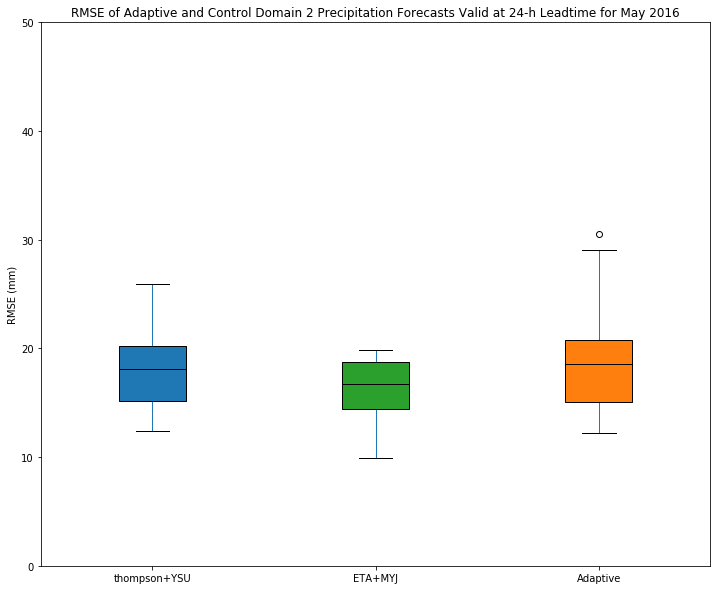

In [159]:
bp = rmse_may_24.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Domain 2 Precipitation Forecasts Valid at 24-h Leadtime for May 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

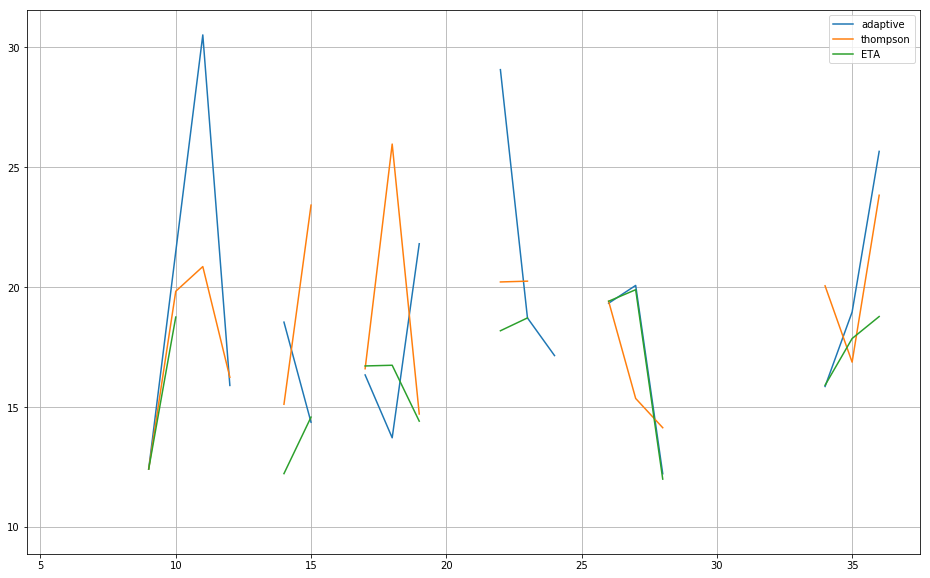

In [157]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.grid()
plt.legend()
plt.show()

In [158]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 18.692039740713017
Mean Thompson RMSE: 18.205342928568523
Mean ETA RMSE: 16.02410748425652


### For a 36-h Leadtime

In [160]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = 'd02'
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
    else:
        domain = 'd02'
        leadtime = 36
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201605_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201605_01h.nc'
        # open the data files
        try:
            adaptive = xr.open_dataset(adp_file)
            thompson = xr.open_dataset(thomp_file)
            ETA = xr.open_dataset(eta_file)
            stage4 = xr.open_dataset(precip_file)
        except FileNotFoundError:
            print('Data not found '+str(date))
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            pass
        # Get just the precipitation for the analogue time
        try:
            adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
            thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
            ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
            obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
        except KeyError:
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            print('Forecast not complete '+str(date))
            pass

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

Data not found 2016-05-10 12:00:00
Forecast not complete 2016-05-10 12:00:00
Data not found 2016-05-14 12:00:00
Forecast not complete 2016-05-14 12:00:00
Data not found 2016-05-16 12:00:00
Forecast not complete 2016-05-16 12:00:00
Data not found 2016-05-24 12:00:00
Forecast not complete 2016-05-24 12:00:00
Data not found 2016-05-27 12:00:00
Forecast not complete 2016-05-27 12:00:00
Data not found 2016-05-28 12:00:00
Forecast not complete 2016-05-28 12:00:00


In [161]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_may_36 = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


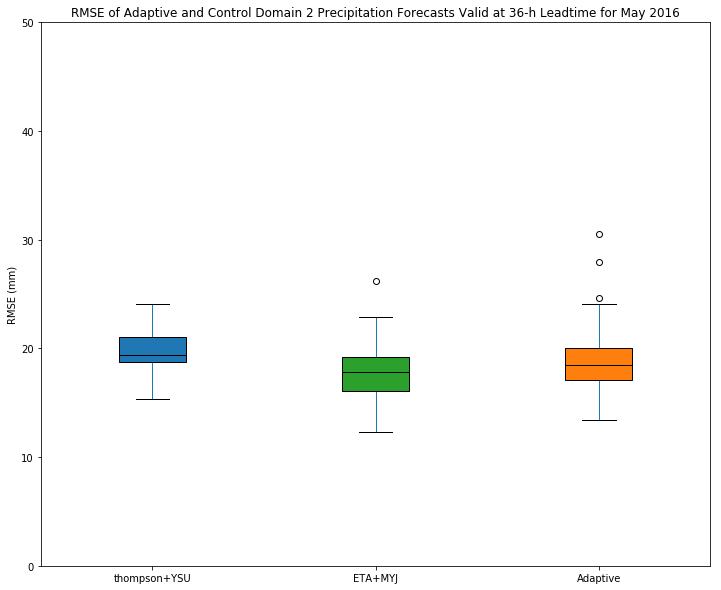

In [162]:
bp = rmse_may_36.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Domain 2 Precipitation Forecasts Valid at 36-h Leadtime for May 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

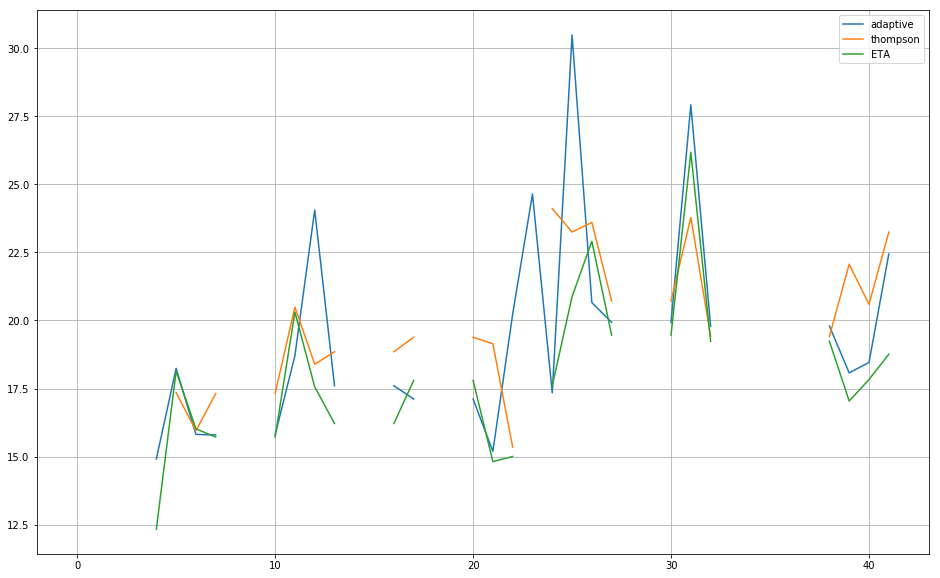

In [163]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.grid()
plt.legend()
plt.show()

In [164]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 19.291049321492512
Mean Thompson RMSE: 19.91913131872813
Mean ETA RMSE: 17.880039801964394


### July 2016 Analogue Leadtimes

Verify adaptive forecasts based on the leadtime for analogue selection. 

In [165]:
# Start by parsing adaptive log file
an_log = pd.read_csv('adaptive_WRF/an_selection_log_201607.log', 
                     delimiter=', ', 
                     header=None, 
                     names=['Date', 'Domain', 'Leadtime', 'MP', 'PBL'],
                     usecols=['Date', 'Domain', 'Leadtime']).sort_values('Date', ascending=True)

In [167]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = str(row['Domain'])
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
    else:
        leadtime = int(row['Leadtime'])
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201607_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201607_01h.nc'
        # open the data files
        try:
            adaptive = xr.open_dataset(adp_file)
            thompson = xr.open_dataset(thomp_file)
            ETA = xr.open_dataset(eta_file)
            stage4 = xr.open_dataset(precip_file)
        except FileNotFoundError:
            print('Data not found '+str(date))
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            pass
        # Get just the precipitation for the analogue time
        try:
            adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
            thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
            ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
            obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
        except KeyError:
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            print('Forecast not complete '+str(date))
            pass

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

In [168]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_july_adp = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


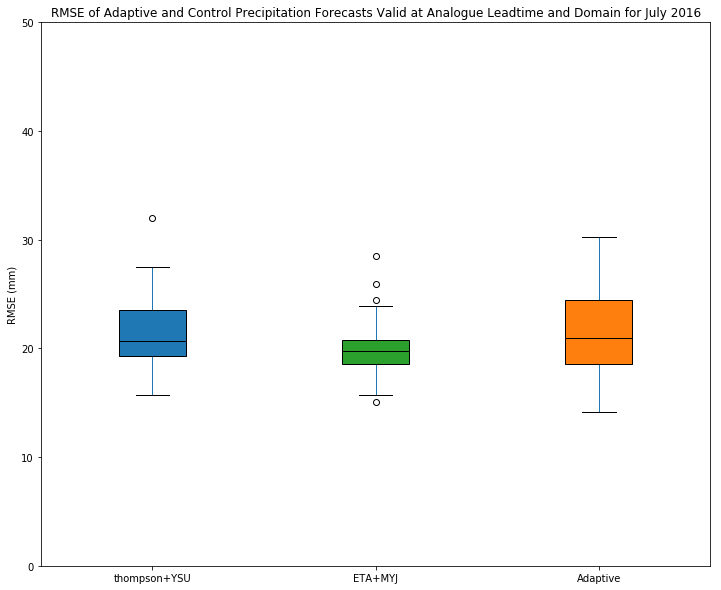

In [169]:
bp = rmse_july_adp.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Precipitation Forecasts Valid at Analogue Leadtime and Domain for July 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

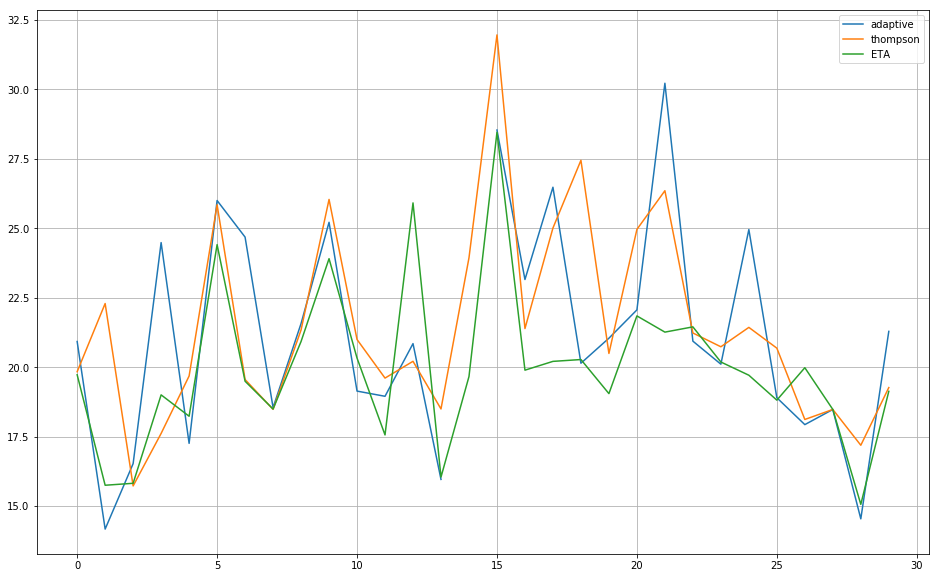

In [47]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.legend()
plt.grid()
plt.show()

In [48]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 21.135523
Mean Thompson RMSE: 21.475939
Mean ETA RMSE: 19.964819


### For a 12-h Leadtime

In [170]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = 'd02'
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
    else:
        domain = 'd02'
        leadtime = 12
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201607_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201607_01h.nc'
        # open the data files
        try:
            adaptive = xr.open_dataset(adp_file)
            thompson = xr.open_dataset(thomp_file)
            ETA = xr.open_dataset(eta_file)
            stage4 = xr.open_dataset(precip_file)
        except FileNotFoundError:
            print('Data not found '+str(date))
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            pass
        # Get just the precipitation for the analogue time
        try:
            adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
            thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
            ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
            obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
        except KeyError:
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            print('Forecast not complete '+str(date))
            pass

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

In [171]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_july_12 = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


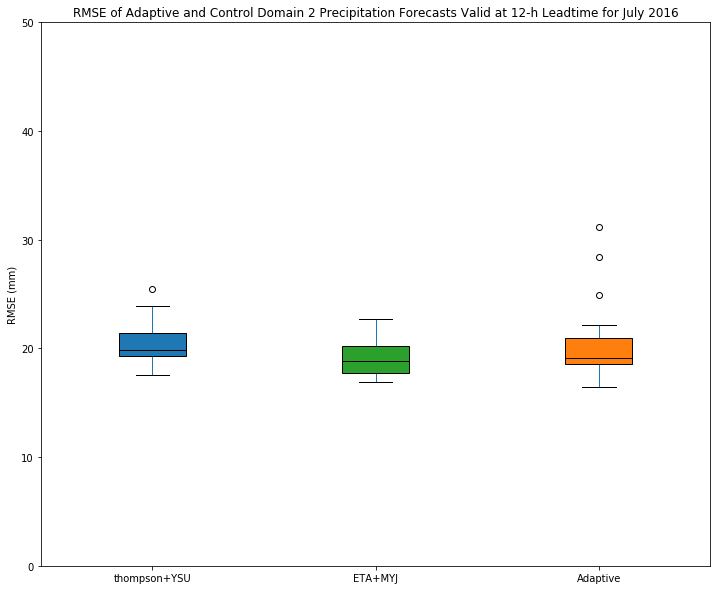

In [172]:
bp = rmse_july_12.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Domain 2 Precipitation Forecasts Valid at 12-h Leadtime for July 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

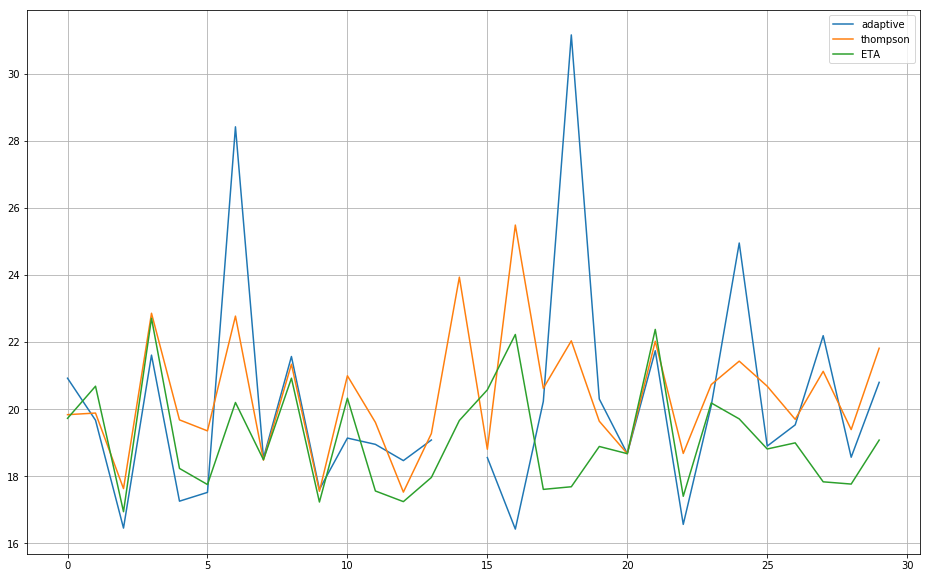

In [173]:
%matplotlib inline
fig = plt.figure(figsize=(16,10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.legend()
plt.grid()
plt.show()

In [174]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 20.131584
Mean Thompson RMSE: 20.382801
Mean ETA RMSE: 19.112406


### For a 24-h Leadtime

In [175]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = 'd02'
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
    else:
        domain = 'd02'
        leadtime = 24
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201607_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201607_01h.nc'
        # open the data files
        try:
            adaptive = xr.open_dataset(adp_file)
            thompson = xr.open_dataset(thomp_file)
            ETA = xr.open_dataset(eta_file)
            stage4 = xr.open_dataset(precip_file)
        except FileNotFoundError:
            print('Data not found '+str(date))
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            pass
        # Get just the precipitation for the analogue time
        try:
            adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
            thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
            ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
            obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
        except KeyError:
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            print('Forecast not complete '+str(date))
            pass

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

In [176]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_july_24 = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


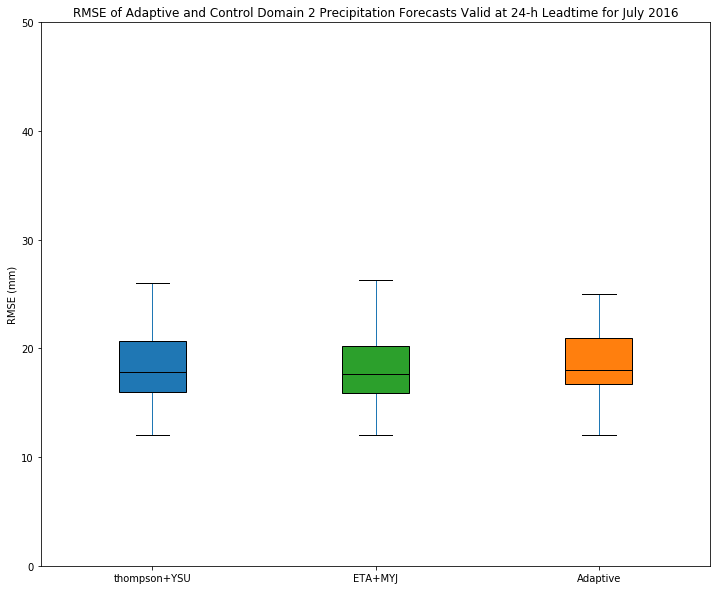

In [177]:
bp = rmse_july_24.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Domain 2 Precipitation Forecasts Valid at 24-h Leadtime for July 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

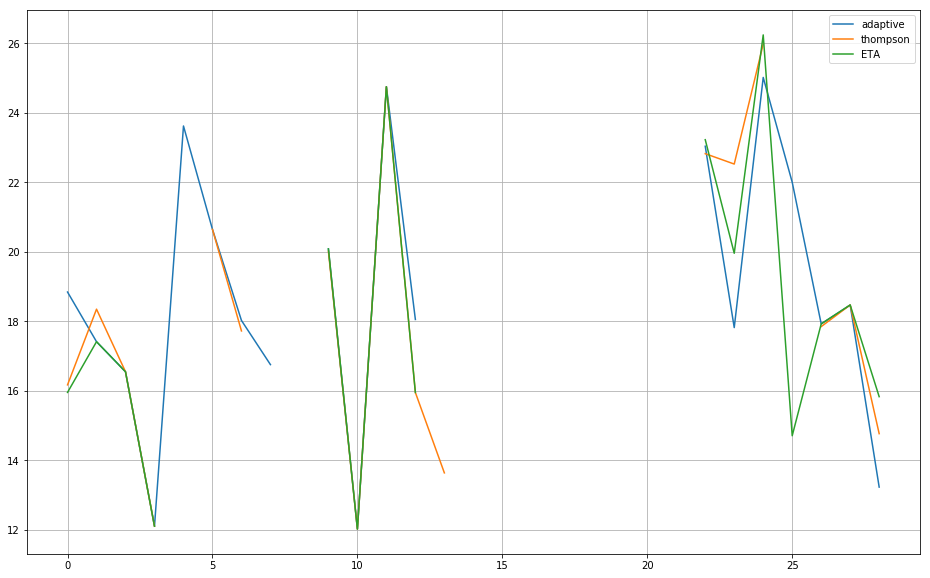

In [178]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.grid()
plt.legend()
plt.show()

In [179]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 18.500528
Mean Thompson RMSE: 18.258116
Mean ETA RMSE: 18.242868


### For a 36-h Leadtime

In [180]:
sigma = 1
thresh = 10
rmse_adaptive = []
rmse_thompson = []
rmse_eta = []
for index, row in an_log.iterrows():
    datestr = str(row['Date'])
    domain = 'd02'
    if domain == 'None':
        print('Skipping None data point')
        rmse_adaptive.append(np.nan)
        rmse_thompson.append(np.nan)
        rmse_eta.append(np.nan)
        pass
    else:
        domain = 'd02'
        leadtime = 36
        date = pd.to_datetime(datestr, format='%Y%m%d%H')
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_201607_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_201607_01h.nc'
        # open the data files
        try:
            adaptive = xr.open_dataset(adp_file)
            thompson = xr.open_dataset(thomp_file)
            ETA = xr.open_dataset(eta_file)
            stage4 = xr.open_dataset(precip_file)
        except FileNotFoundError:
            print('Data not found '+str(date))
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            pass
        # Get just the precipitation for the analogue time
        try:
            adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
            thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
            ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
            obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
        except KeyError:
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
            print('Forecast not complete '+str(date))
            pass

        # smooth the forecast and observed fields
        adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
        thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
        ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
        obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

        # Mask the forecast fields
        adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
        ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

        # Calculate RMSE
        rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
        rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

In [181]:
with ProgressBar():
    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    
data = {
    'thompson+YSU': np.array(thompson_rmse),
    'ETA+MYJ': np.array(ETA_rmse),
    'Adaptive': np.array(adaptive_rmse)
}

rmse_july_36 = pd.DataFrame(data=data)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


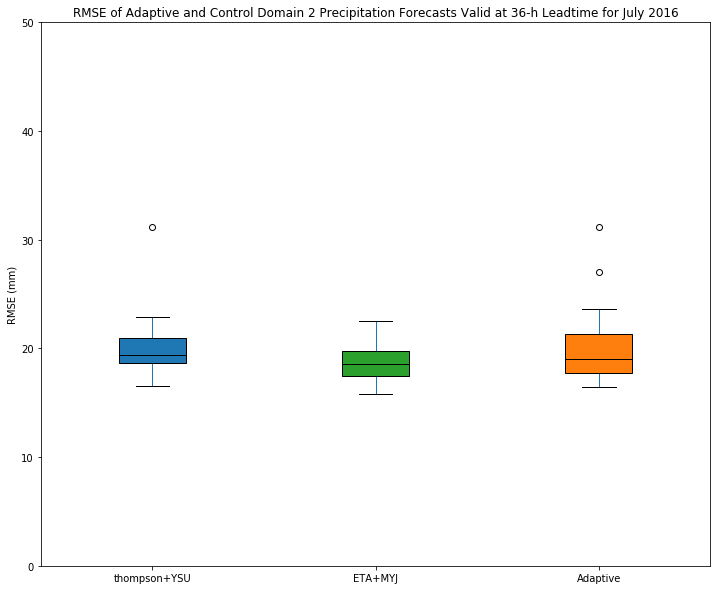

In [182]:
bp = rmse_july_36.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Domain 2 Precipitation Forecasts Valid at 36-h Leadtime for July 2016')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

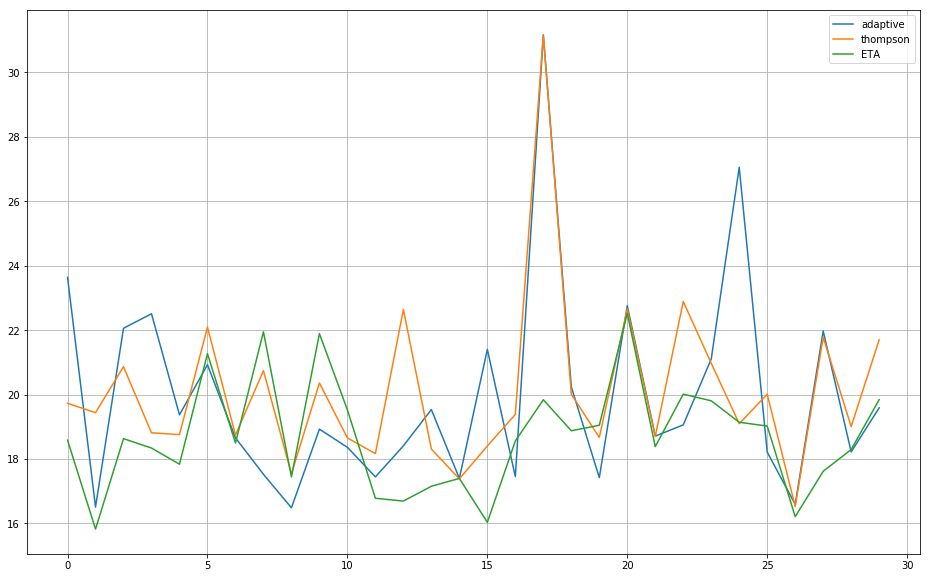

In [183]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
plt.plot(adaptive_rmse, label='adaptive')
plt.plot(thompson_rmse, label='thompson')
plt.plot(ETA_rmse, label='ETA')
plt.grid()
plt.legend()
plt.show()

In [184]:
adp_mean = np.nanmean(adaptive_rmse)
thomp_mean = np.nanmean(thompson_rmse)
eta_mean = np.nanmean(ETA_rmse)
print('Mean Adaptive RMSE: '+str(adp_mean))
print('Mean Thompson RMSE: '+str(thomp_mean))
print('Mean ETA RMSE: '+str(eta_mean))

Mean Adaptive RMSE: 19.955408
Mean Thompson RMSE: 20.105019
Mean ETA RMSE: 18.699924


## All Cases

36 hr Leadtime

In [24]:
all_dates = []
for date in pd.date_range(start='2016-01-02T12', end='2016-01-31T12', freq='1D'):
    all_dates.append(date)
for date in pd.date_range(start='2016-05-02T12', end='2016-05-31T12', freq='1D'):
    all_dates.append(date)
for date in pd.date_range(start='2016-07-02T12', end='2016-07-31T12', freq='1D'):
    all_dates.append(date)
    
missing_dates = [pd.Timestamp(2016, 1, 12, 12),
                 pd.Timestamp(2016, 1, 13, 12),
                 pd.Timestamp(2016, 1, 6, 12),
                 pd.Timestamp(2016, 5, 11, 12),
                 pd.Timestamp(2016, 1, 24, 12),
                 pd.Timestamp(2016, 1, 25, 12),
                 pd.Timestamp(2016, 5, 10, 12),
                 pd.Timestamp(2016, 5, 27, 12),
                 pd.Timestamp(2016, 5, 24, 12),
                 pd.Timestamp(2016, 5, 14, 12),
                 pd.Timestamp(2016, 5, 16, 12),
                 pd.Timestamp(2016, 5, 31, 12),
                 pd.Timestamp(2016, 5, 28, 12)]

for missing in missing_dates:
    if missing in all_dates:
        all_dates.remove(missing)

In [25]:
sigma = 1
thresh = 10
data = {}
# domain = 'd01'
for domain in ['d01', 'd02']:
    rmse_adaptive = []
    rmse_thompson = []
    rmse_eta = []
    for date in all_dates:
        datestr = date.strftime('%Y%m%d%H')
        leadtime = 36
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_01h.nc'
        # open the data files
        try:
            adaptive = xr.open_dataset(adp_file)
            thompson = xr.open_dataset(thomp_file)
            ETA = xr.open_dataset(eta_file)
            stage4 = xr.open_dataset(precip_file)
        except FileNotFoundError:
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
        else:
            # Get just the precipitation for the analogue time
            try:
                adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
                thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
                ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
                obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
            except KeyError:
                rmse_adaptive.append(np.nan)
                rmse_thompson.append(np.nan)
                rmse_eta.append(np.nan)
                
            except AttributeError:
                rmse_adaptive.append(np.nan)
                rmse_thompson.append(np.nan)
                rmse_eta.append(np.nan)
            else:

                # smooth the forecast and observed fields
                adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
                thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
                ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
                obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

                # Mask the forecast fields
                adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

                # Calculate RMSE
                rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    data['thompson+YSU-'+domain] = np.array(thompson_rmse)
    data['ETA+MYJ-'+domain] = np.array(ETA_rmse)
    data['Adaptive-'+domain] = np.array(adaptive_rmse)

In [26]:
data['Date'] = np.array(all_dates)
rmse_all_36 = pd.DataFrame(data=data)

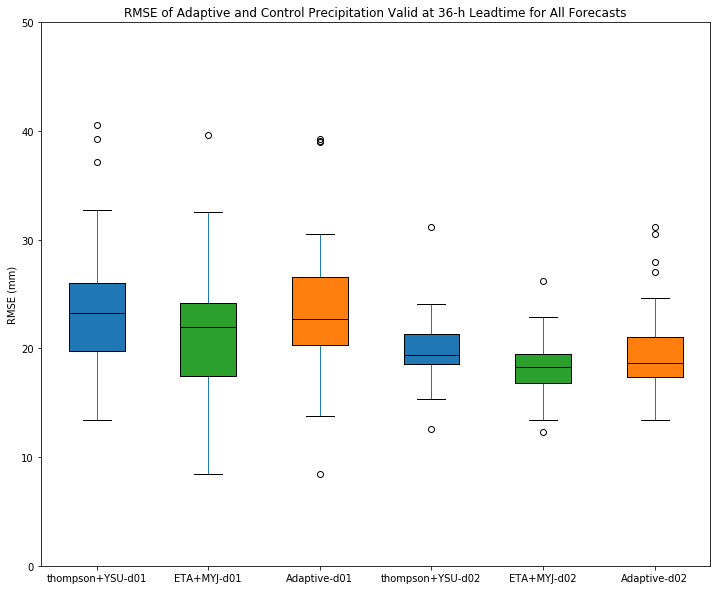

In [27]:
keys = [key for key in rmse_all_36.keys()]
keys.remove('Date')
bp = rmse_all_36[keys].plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Precipitation Valid at 36-h Leadtime for All Forecasts')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

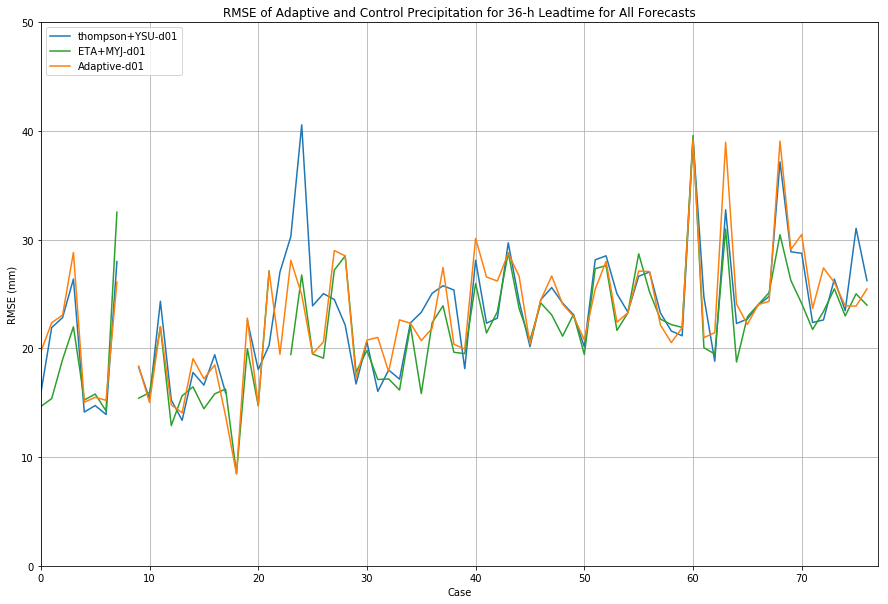

In [28]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
for key, color in zip(keys[0:3], colors[0:3]):
    plt.plot(rmse_all_36[key], color=color, label=key)
plt.ylim(0, 50)
plt.xlim(0, len(all_dates))
plt.grid()
plt.xlabel('Case')
plt.ylabel('RMSE (mm)')
plt.title('RMSE of Adaptive and Control Precipitation for 36-h Leadtime for All Forecasts')
plt.legend(loc=2)
plt.show()

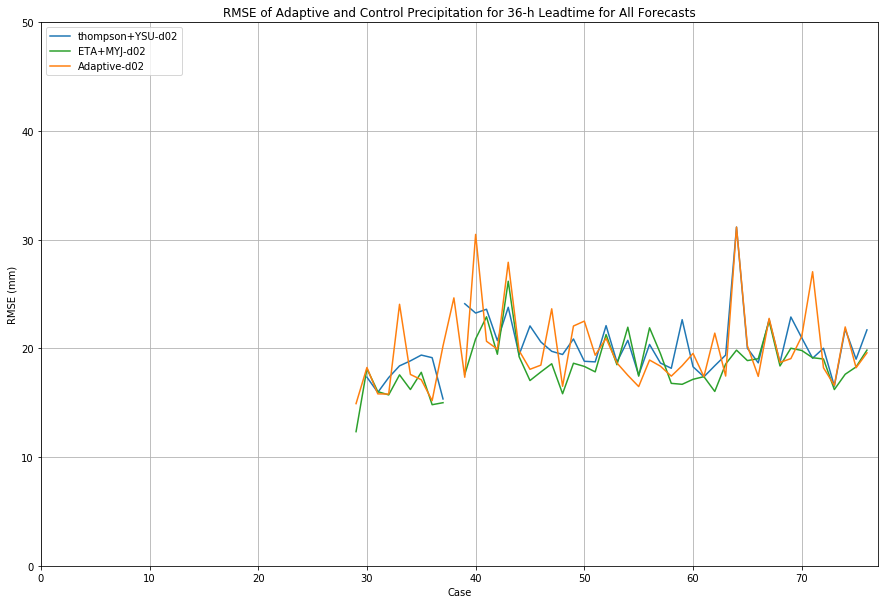

In [29]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
for key, color in zip(keys[3:], colors[3:]):
    plt.plot(rmse_all_36[key], color=color, label=key)
plt.ylim(0, 50)
plt.xlim(0, len(all_dates))
plt.grid()
plt.xlabel('Case')
plt.ylabel('RMSE (mm)')
plt.title('RMSE of Adaptive and Control Precipitation for 36-h Leadtime for All Forecasts')
plt.legend(loc=2)
plt.show()

### 24-h Leadtime

In [30]:
sigma = 1
thresh = 10
data = {}
# domain = 'd01'
for domain in ['d01', 'd02']:
    rmse_adaptive = []
    rmse_thompson = []
    rmse_eta = []
    for date in all_dates:
        datestr = date.strftime('%Y%m%d%H')
        leadtime = 24
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_01h.nc'
        # open the data files
        try:
            adaptive = xr.open_dataset(adp_file)
            thompson = xr.open_dataset(thomp_file)
            ETA = xr.open_dataset(eta_file)
            stage4 = xr.open_dataset(precip_file)
        except FileNotFoundError:
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
        else:
            # Get just the precipitation for the analogue time
            try:
                adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
                thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
                ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
                obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
            except KeyError:
                rmse_adaptive.append(np.nan)
                rmse_thompson.append(np.nan)
                rmse_eta.append(np.nan)
                
            except AttributeError:
                rmse_adaptive.append(np.nan)
                rmse_thompson.append(np.nan)
                rmse_eta.append(np.nan)
            else:

                # smooth the forecast and observed fields
                adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
                thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
                ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
                obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

                # Mask the forecast fields
                adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

                # Calculate RMSE
                rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    data['thompson+YSU-'+domain] = np.array(thompson_rmse)
    data['ETA+MYJ-'+domain] = np.array(ETA_rmse)
    data['Adaptive-'+domain] = np.array(adaptive_rmse)

In [31]:
data['Date'] = np.array(all_dates)
rmse_all_24 = pd.DataFrame(data=data)

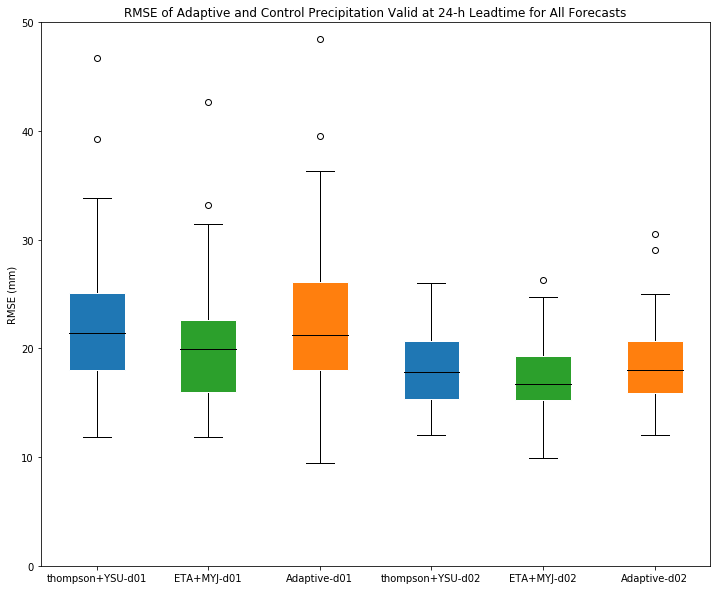

In [32]:
keys = [key for key in rmse_all_36.keys()]
keys.remove('Date')
bp = rmse_all_24[keys].plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'white', 'whiskers': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Precipitation Valid at 24-h Leadtime for All Forecasts')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

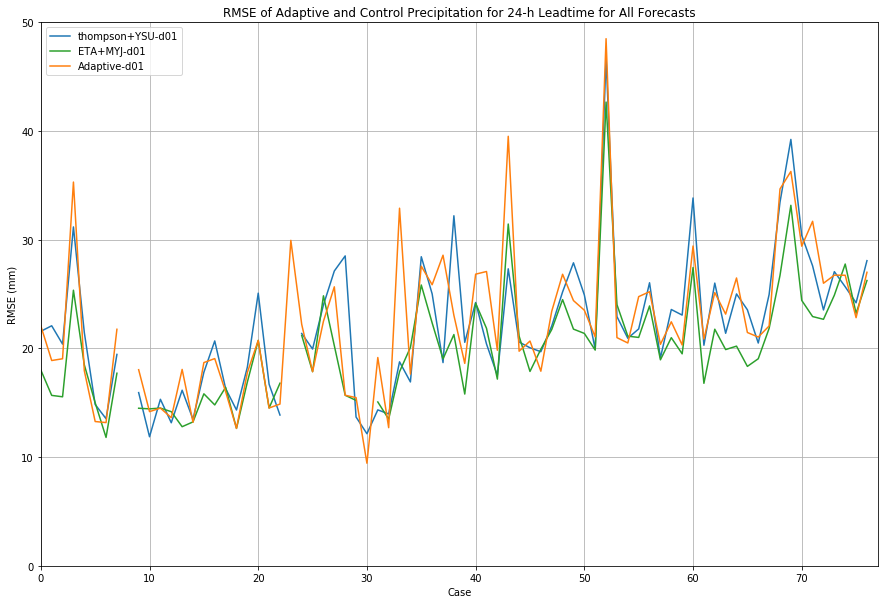

In [33]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
for key, color in zip(keys[0:3], colors[0:3]):
    plt.plot(rmse_all_24[key], color=color, label=key)
plt.ylim(0, 50)
plt.xlim(0, len(all_dates))
plt.grid()
plt.xlabel('Case')
plt.ylabel('RMSE (mm)')
plt.title('RMSE of Adaptive and Control Precipitation for 24-h Leadtime for All Forecasts')
plt.legend(loc=2)
plt.show()

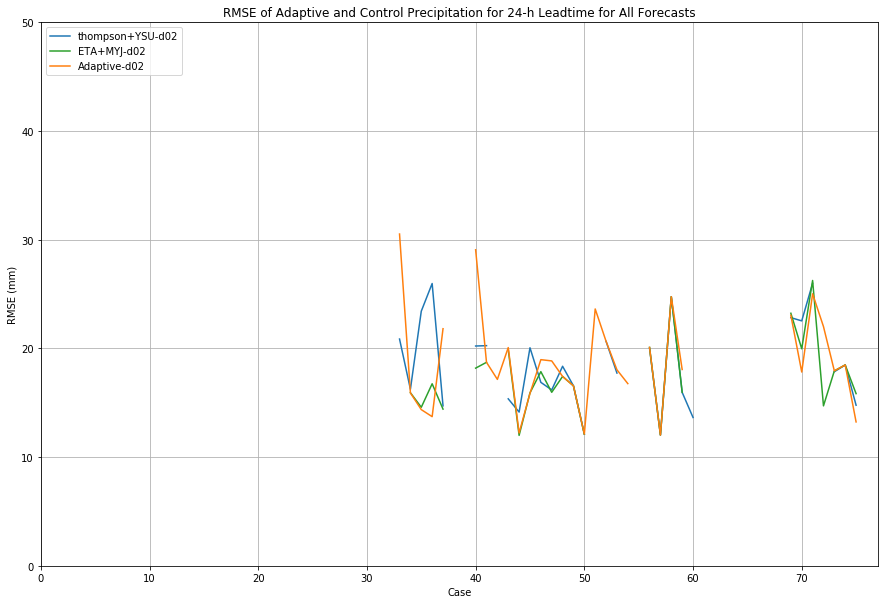

In [34]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
for key, color in zip(keys[3:], colors[3:]):
    plt.plot(rmse_all_24[key], color=color, label=key)
plt.ylim(0, 50)
plt.xlim(0, len(all_dates))
plt.grid()
plt.xlabel('Case')
plt.ylabel('RMSE (mm)')
plt.title('RMSE of Adaptive and Control Precipitation for 24-h Leadtime for All Forecasts')
plt.legend(loc=2)
plt.show()

### 12-h Leadtime

In [35]:
sigma = 1
thresh = 10
data = {}
# domain = 'd01'
for domain in ['d01', 'd02']:
    rmse_adaptive = []
    rmse_thompson = []
    rmse_eta = []
    for date in all_dates:
        datestr = date.strftime('%Y%m%d%H')
        leadtime = 12
        verif_time = date + pd.Timedelta(hours=leadtime)
        # Parse the correct file paths
        adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
        if domain == 'd01':
            precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_03h.nc'
        else:
            precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_01h.nc'
        # open the data files
        try:
            adaptive = xr.open_dataset(adp_file)
            thompson = xr.open_dataset(thomp_file)
            ETA = xr.open_dataset(eta_file)
            stage4 = xr.open_dataset(precip_file)
        except FileNotFoundError:
            rmse_adaptive.append(np.nan)
            rmse_thompson.append(np.nan)
            rmse_eta.append(np.nan)
        else:
            # Get just the precipitation for the analogue time
            try:
                adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
                thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
                ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
                obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
            except KeyError:
                rmse_adaptive.append(np.nan)
                rmse_thompson.append(np.nan)
                rmse_eta.append(np.nan)
                
            except AttributeError:
                rmse_adaptive.append(np.nan)
                rmse_thompson.append(np.nan)
                rmse_eta.append(np.nan)
            else:

                # smooth the forecast and observed fields
                adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
                thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
                ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
                obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

                # Mask the forecast fields
                adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

                # Calculate RMSE
                rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

    adaptive_rmse = dask.compute(*rmse_adaptive)
    thompson_rmse = dask.compute(*rmse_thompson)
    ETA_rmse = dask.compute(*rmse_eta)
    data['thompson+YSU-'+domain] = np.array(thompson_rmse)
    data['ETA+MYJ-'+domain] = np.array(ETA_rmse)
    data['Adaptive-'+domain] = np.array(adaptive_rmse)

In [36]:
data['Date'] = np.array(all_dates)
rmse_all_12 = pd.DataFrame(data=data)

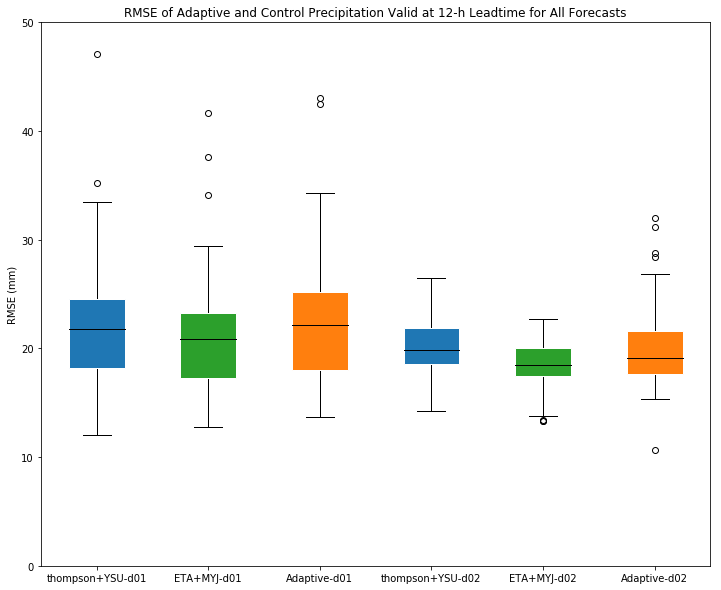

In [37]:
keys = [key for key in rmse_all_36.keys()]
keys.remove('Date')
bp = rmse_all_12[keys].plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'white', 'whiskers': 'k'}, return_type='dict',  patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:blue', 'tab:green', 'tab:orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('RMSE of Adaptive and Control Precipitation Valid at 12-h Leadtime for All Forecasts')
plt.ylabel('RMSE (mm)')
plt.ylim(0, 50)
plt.show()

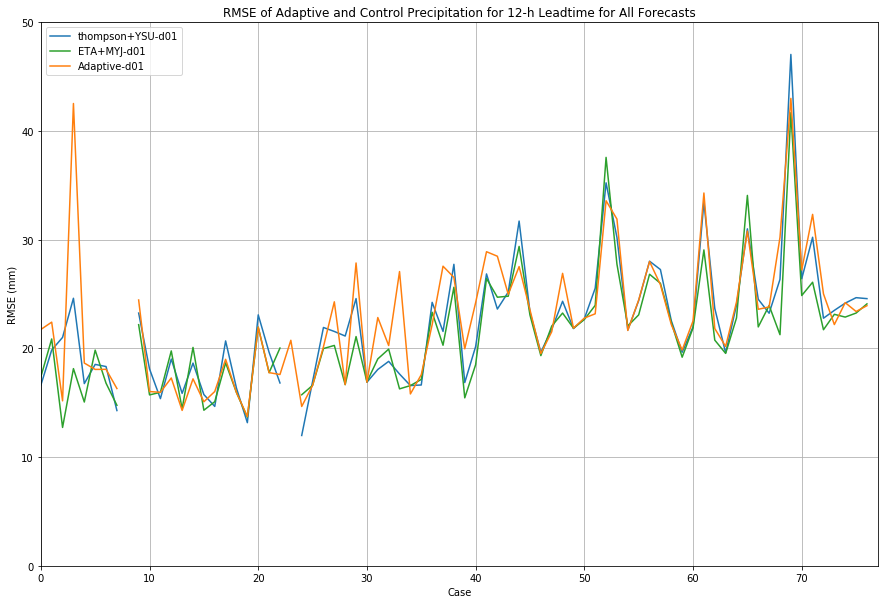

In [38]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
for key, color in zip(keys[0:3], colors[0:3]):
    plt.plot(rmse_all_12[key], color=color, label=key)
plt.ylim(0, 50)
plt.xlim(0, len(all_dates))
plt.grid()
plt.xlabel('Case')
plt.ylabel('RMSE (mm)')
plt.title('RMSE of Adaptive and Control Precipitation for 12-h Leadtime for All Forecasts')
plt.legend(loc=2)
plt.show()

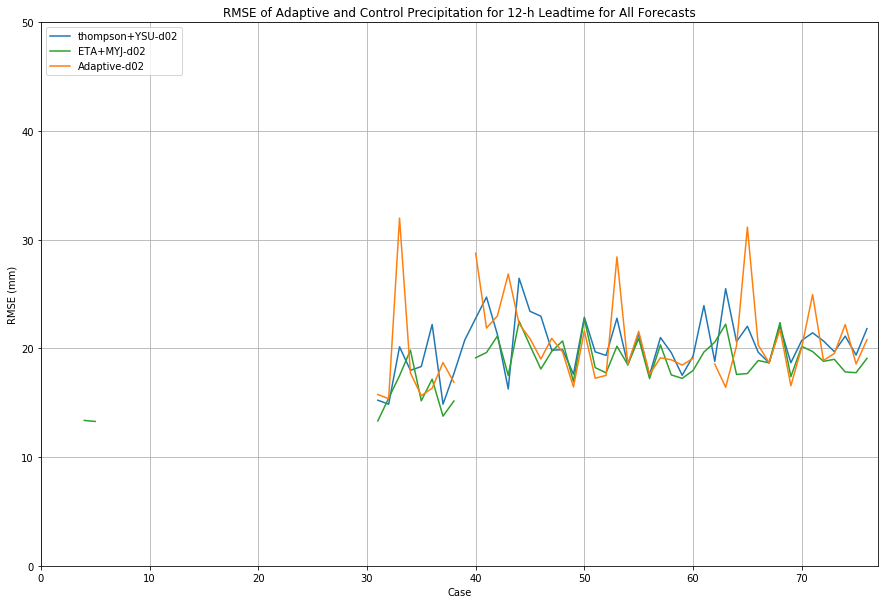

In [39]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
for key, color in zip(keys[3:], colors[3:]):
    plt.plot(rmse_all_12[key], color=color, label=key)
plt.ylim(0, 50)
plt.xlim(0, len(all_dates))
plt.grid()
plt.xlabel('Case')
plt.ylabel('RMSE (mm)')
plt.title('RMSE of Adaptive and Control Precipitation for 12-h Leadtime for All Forecasts')
plt.legend(loc=2)
plt.show()

### Final Figures for Each Season

#### January 2016

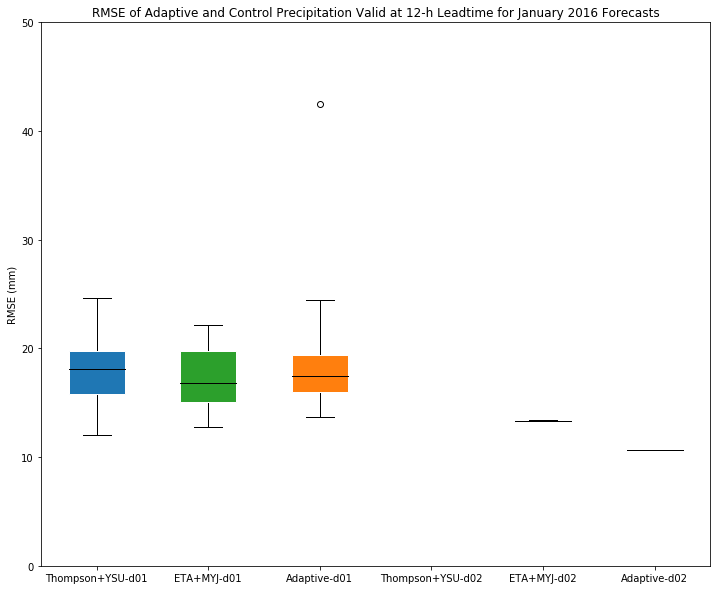

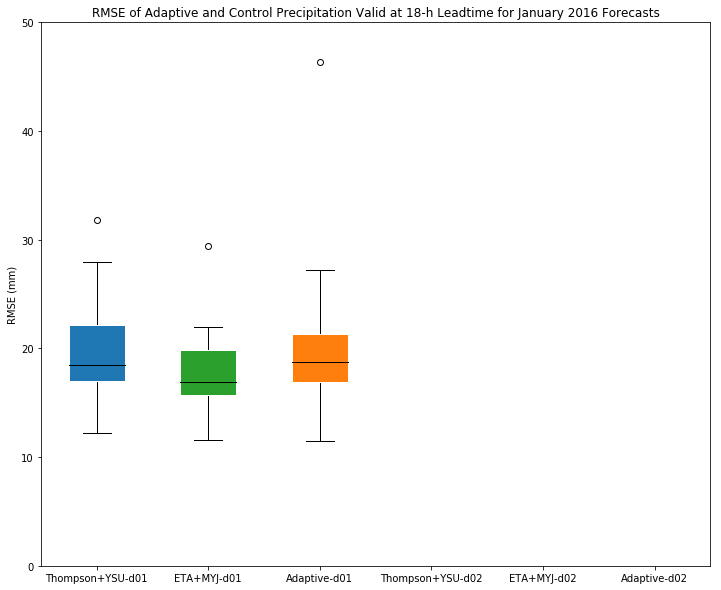

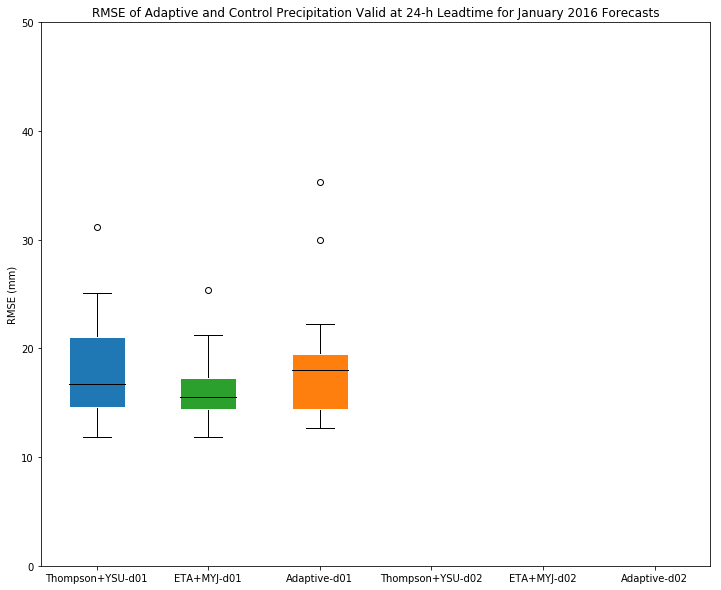

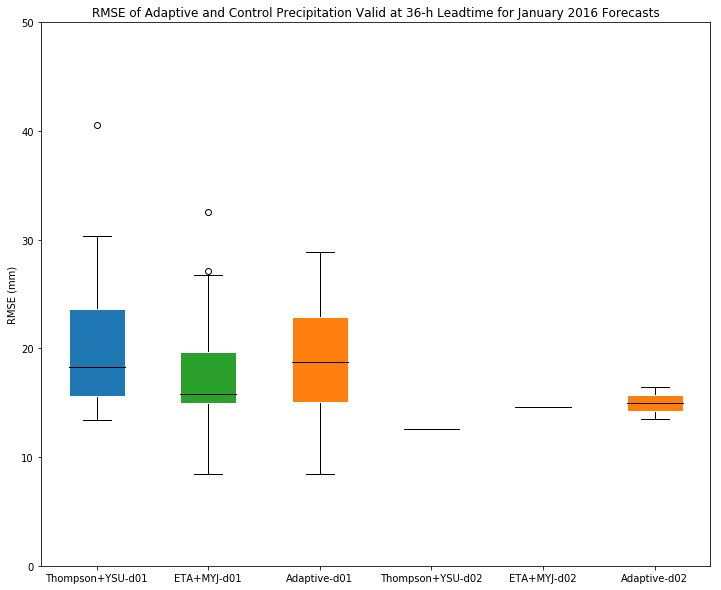

In [20]:
dates = list(pd.date_range(start='2016-01-02T12',
                     end='2016-01-31T12',
                     freq='1D'))
for missing in missing_dates:
    if missing in dates:
        dates.remove(missing)
sigma = 1
thresh = 10
data = {}
# domain = 'd01'
for leadtime in [12, 18, 24, 36]:
    for domain in ['d01', 'd02']:
        rmse_adaptive = []
        rmse_thompson = []
        rmse_eta = []
        for date in dates:
            datestr = date.strftime('%Y%m%d%H')
            verif_time = date + pd.Timedelta(hours=leadtime)
            # Parse the correct file paths
            adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            if domain == 'd01':
                precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_03h.nc'
            else:
                precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_01h.nc'
            # open the data files
            try:
                adaptive = xr.open_dataset(adp_file)
                thompson = xr.open_dataset(thomp_file)
                ETA = xr.open_dataset(eta_file)
                stage4 = xr.open_dataset(precip_file)
            except FileNotFoundError:
                rmse_adaptive.append(np.nan)
                rmse_thompson.append(np.nan)
                rmse_eta.append(np.nan)
            else:
                # Get just the precipitation for the analogue time
                try:
                    adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
                    thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
                    ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
                    obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
                except KeyError:
                    rmse_adaptive.append(np.nan)
                    rmse_thompson.append(np.nan)
                    rmse_eta.append(np.nan)

                except AttributeError:
                    rmse_adaptive.append(np.nan)
                    rmse_thompson.append(np.nan)
                    rmse_eta.append(np.nan)
                else:

                    # smooth the forecast and observed fields
                    adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
                    thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
                    ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
                    obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

                    # Mask the forecast fields
                    adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                    thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                    ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

                    # Calculate RMSE
                    rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                    rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                    rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

        adaptive_rmse = dask.compute(*rmse_adaptive)
        thompson_rmse = dask.compute(*rmse_thompson)
        ETA_rmse = dask.compute(*rmse_eta)
        data['Thompson+YSU-'+domain] = np.array(thompson_rmse)
        data['ETA+MYJ-'+domain] = np.array(ETA_rmse)
        data['Adaptive-'+domain] = np.array(adaptive_rmse)

    rmse = pd.DataFrame(data=data)
    bp = rmse.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'white', 'whiskers': 'k'}, return_type='dict',  patch_artist=True)
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:blue', 'tab:green', 'tab:orange']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    plt.title('RMSE of Adaptive and Control Precipitation Valid at '+str(leadtime)+'-h Leadtime for January 2016 Forecasts')
    plt.ylabel('RMSE (mm)')
    plt.ylim(0, 50)
    plt.show()

#### May 2016

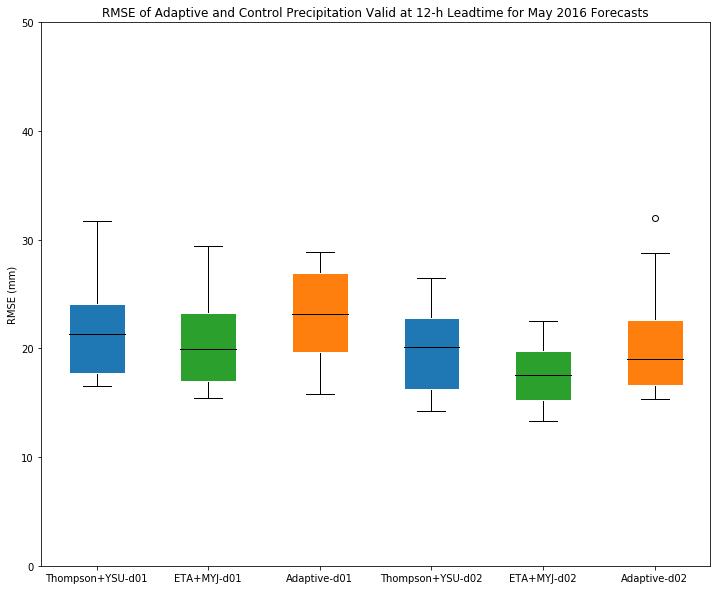

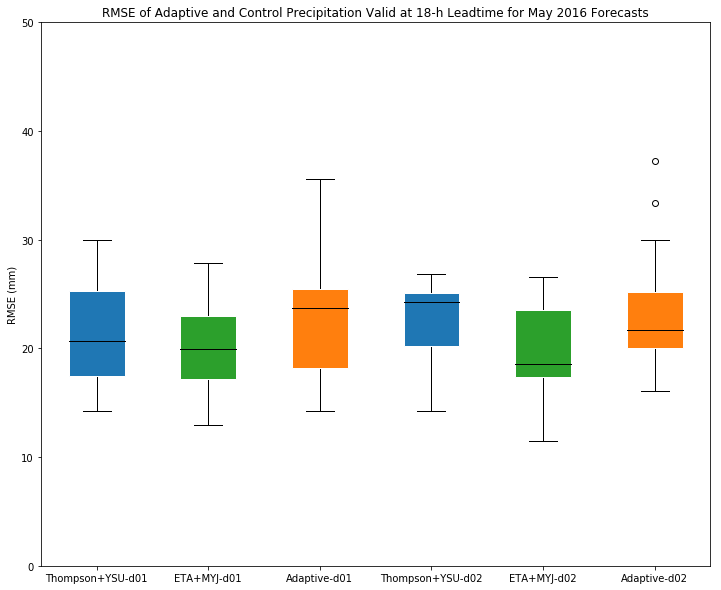

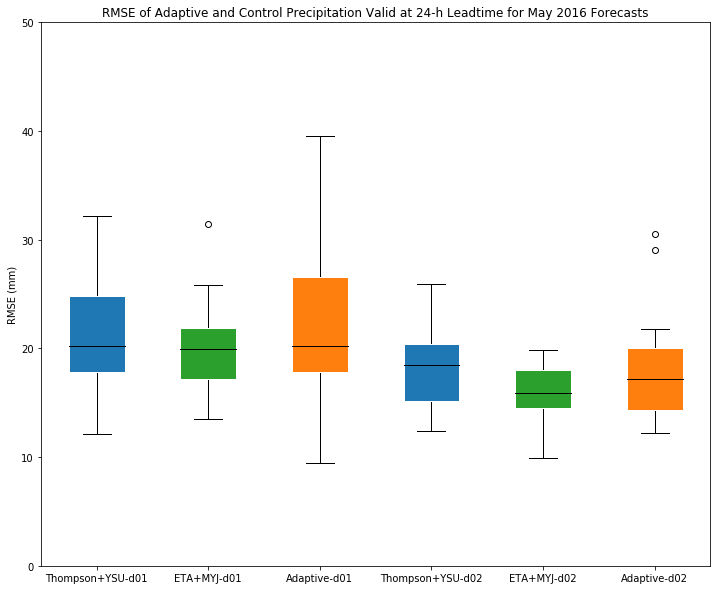

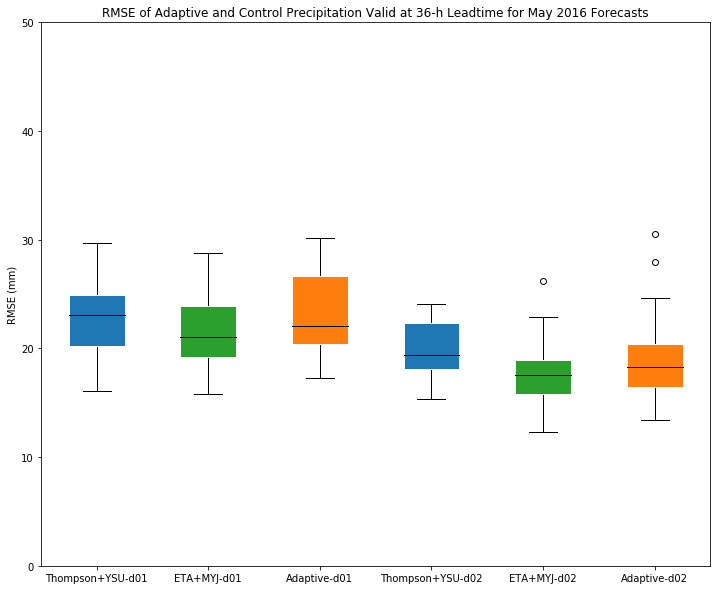

In [21]:
dates = list(pd.date_range(start='2016-05-02T12',
                     end='2016-05-31T12',
                     freq='1D'))
for missing in missing_dates:
    if missing in dates:
        dates.remove(missing)
sigma = 1
thresh = 10
data = {}
# domain = 'd01'
for leadtime in [12, 18, 24, 36]:
    for domain in ['d01', 'd02']:
        rmse_adaptive = []
        rmse_thompson = []
        rmse_eta = []
        for date in dates:
            datestr = date.strftime('%Y%m%d%H')
            verif_time = date + pd.Timedelta(hours=leadtime)
            # Parse the correct file paths
            adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            if domain == 'd01':
                precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_03h.nc'
            else:
                precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_01h.nc'
            # open the data files
            try:
                adaptive = xr.open_dataset(adp_file)
                thompson = xr.open_dataset(thomp_file)
                ETA = xr.open_dataset(eta_file)
                stage4 = xr.open_dataset(precip_file)
            except FileNotFoundError:
                rmse_adaptive.append(np.nan)
                rmse_thompson.append(np.nan)
                rmse_eta.append(np.nan)
            else:
                # Get just the precipitation for the analogue time
                try:
                    adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
                    thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
                    ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
                    obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
                except KeyError:
                    rmse_adaptive.append(np.nan)
                    rmse_thompson.append(np.nan)
                    rmse_eta.append(np.nan)

                except AttributeError:
                    rmse_adaptive.append(np.nan)
                    rmse_thompson.append(np.nan)
                    rmse_eta.append(np.nan)
                else:

                    # smooth the forecast and observed fields
                    adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
                    thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
                    ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
                    obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

                    # Mask the forecast fields
                    adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                    thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                    ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

                    # Calculate RMSE
                    rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                    rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                    rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

        adaptive_rmse = dask.compute(*rmse_adaptive)
        thompson_rmse = dask.compute(*rmse_thompson)
        ETA_rmse = dask.compute(*rmse_eta)
        data['Thompson+YSU-'+domain] = np.array(thompson_rmse)
        data['ETA+MYJ-'+domain] = np.array(ETA_rmse)
        data['Adaptive-'+domain] = np.array(adaptive_rmse)

    rmse = pd.DataFrame(data=data)
    bp = rmse.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'white', 'whiskers': 'k'}, return_type='dict',  patch_artist=True)
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:blue', 'tab:green', 'tab:orange']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    plt.title('RMSE of Adaptive and Control Precipitation Valid at '+str(leadtime)+'-h Leadtime for May 2016 Forecasts')
    plt.ylabel('RMSE (mm)')
    plt.ylim(0, 50)
    plt.show()

#### July 2016

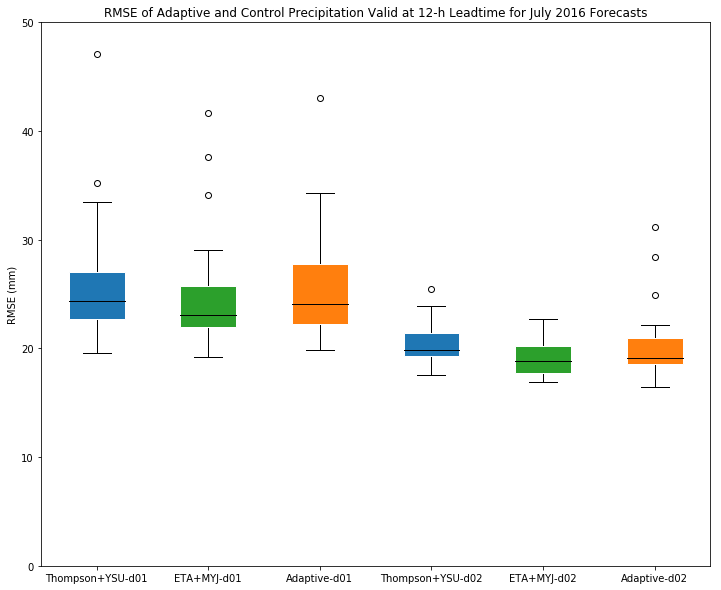

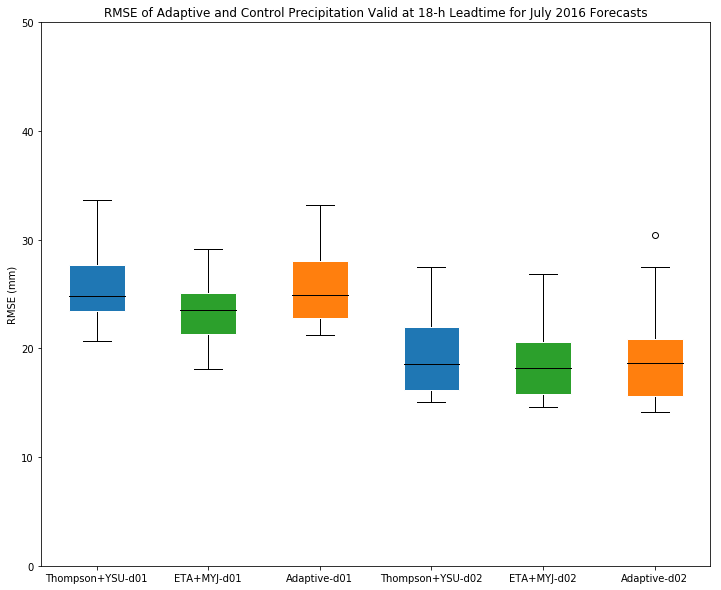

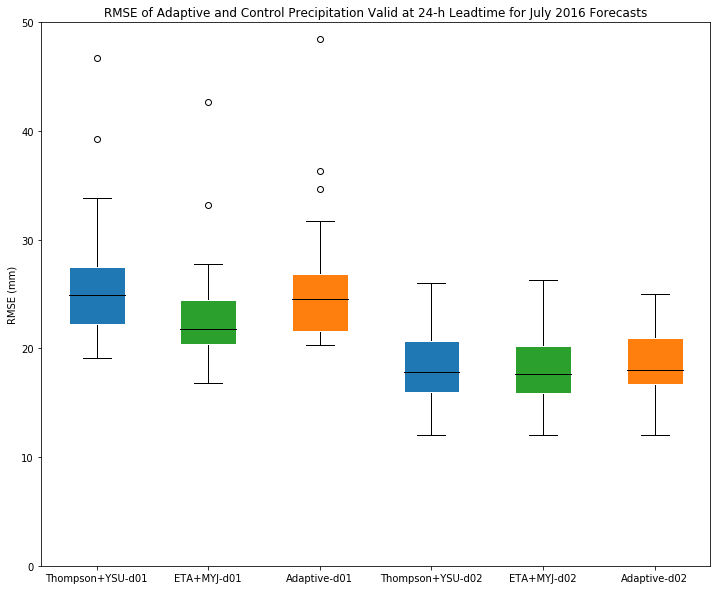

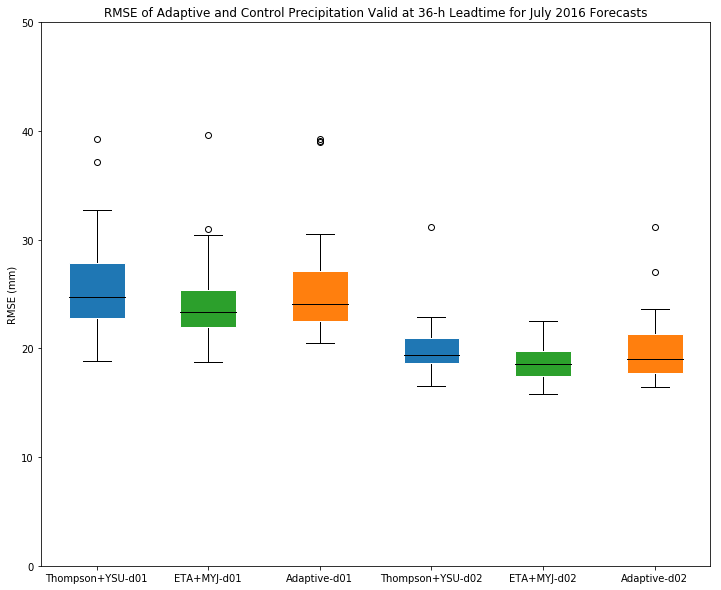

In [22]:
dates = list(pd.date_range(start='2016-07-02T12',
                     end='2016-07-31T12',
                     freq='1D'))
for missing in missing_dates:
    if missing in dates:
        dates.remove(missing)
sigma = 1
thresh = 10
data = {}
# domain = 'd01'
for leadtime in [12, 18, 24, 36]:
    for domain in ['d01', 'd02']:
        rmse_adaptive = []
        rmse_thompson = []
        rmse_eta = []
        for date in dates:
            datestr = date.strftime('%Y%m%d%H')
            verif_time = date + pd.Timedelta(hours=leadtime)
            # Parse the correct file paths
            adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            if domain == 'd01':
                precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_03h.nc'
            else:
                precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_01h.nc'
            # open the data files
            try:
                adaptive = xr.open_dataset(adp_file)
                thompson = xr.open_dataset(thomp_file)
                ETA = xr.open_dataset(eta_file)
                stage4 = xr.open_dataset(precip_file)
            except FileNotFoundError:
                rmse_adaptive.append(np.nan)
                rmse_thompson.append(np.nan)
                rmse_eta.append(np.nan)
            else:
                # Get just the precipitation for the analogue time
                try:
                    adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
                    thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
                    ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
                    obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
                except KeyError:
                    rmse_adaptive.append(np.nan)
                    rmse_thompson.append(np.nan)
                    rmse_eta.append(np.nan)

                except AttributeError:
                    rmse_adaptive.append(np.nan)
                    rmse_thompson.append(np.nan)
                    rmse_eta.append(np.nan)
                else:

                    # smooth the forecast and observed fields
                    adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
                    thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
                    ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
                    obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

                    # Mask the forecast fields
                    adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                    thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                    ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

                    # Calculate RMSE
                    rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                    rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                    rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

        adaptive_rmse = dask.compute(*rmse_adaptive)
        thompson_rmse = dask.compute(*rmse_thompson)
        ETA_rmse = dask.compute(*rmse_eta)
        data['Thompson+YSU-'+domain] = np.array(thompson_rmse)
        data['ETA+MYJ-'+domain] = np.array(ETA_rmse)
        data['Adaptive-'+domain] = np.array(adaptive_rmse)

    rmse = pd.DataFrame(data=data)
    bp = rmse.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'white', 'whiskers': 'k'}, return_type='dict',  patch_artist=True)
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:blue', 'tab:green', 'tab:orange']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    plt.title('RMSE of Adaptive and Control Precipitation Valid at '+str(leadtime)+'-h Leadtime for July 2016 Forecasts')
    plt.ylabel('RMSE (mm)')
    plt.ylim(0, 50)
    plt.show()

#### All Forecasts

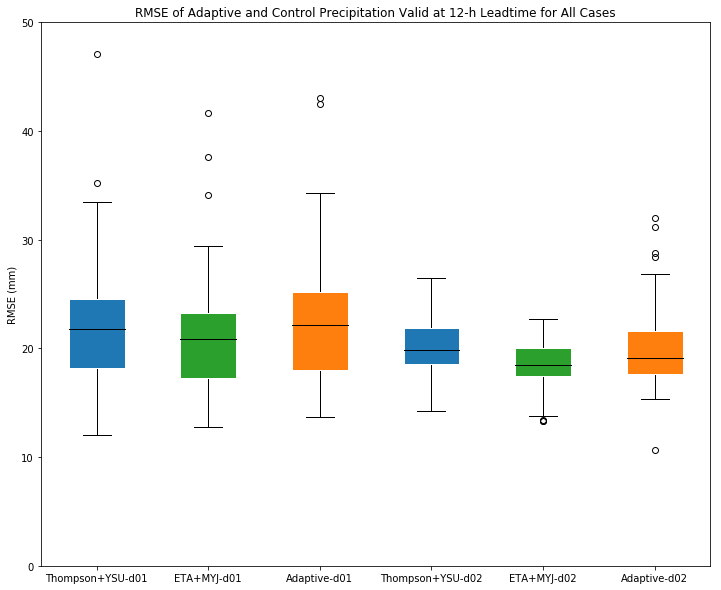

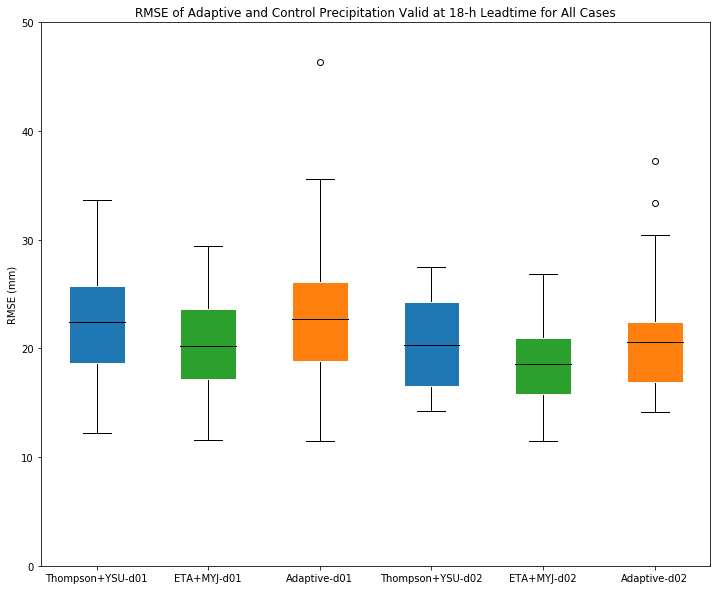

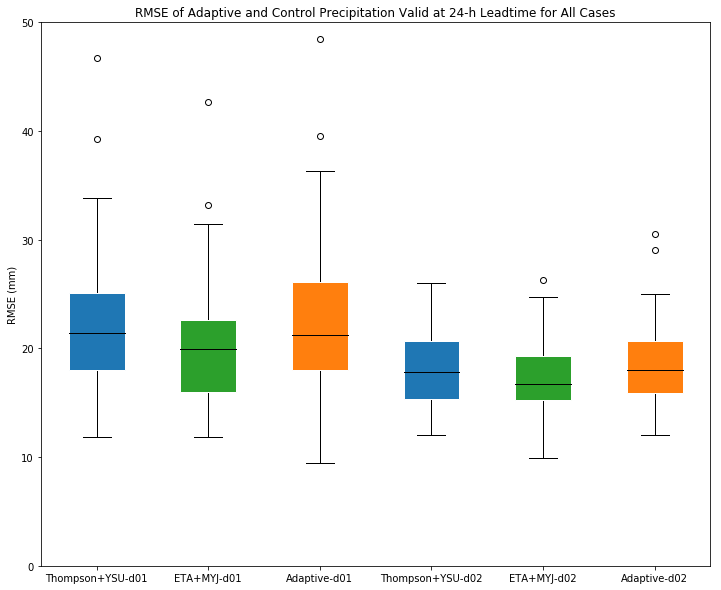

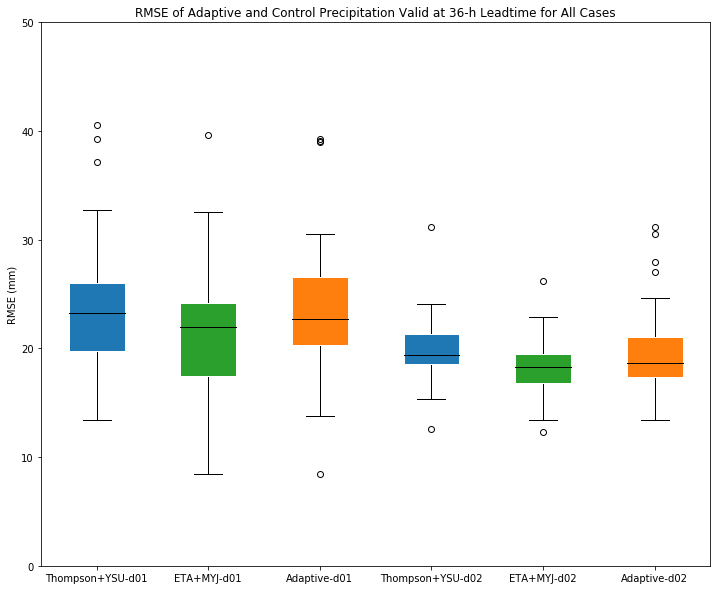

In [23]:
sigma = 1
thresh = 10
data = {}
# domain = 'd01'
for leadtime in [12, 18, 24, 36]:
    for domain in ['d01', 'd02']:
        rmse_adaptive = []
        rmse_thompson = []
        rmse_eta = []
        for date in all_dates:
            datestr = date.strftime('%Y%m%d%H')
            verif_time = date + pd.Timedelta(hours=leadtime)
            # Parse the correct file paths
            adp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/adaptive_wrf/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            thomp_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_thompson/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            eta_file = '/lustre/scratch/twixtrom/adaptive_wrf_post/control_ETA/'+datestr+'/wrfprst_'+domain+'_'+datestr+'.nc'
            if domain == 'd01':
                precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_03h.nc'
            else:
                precip_file = '/lustre/scratch/twixtrom/ST4_2016'+date.strftime('%m')+'_01h.nc'
            # open the data files
            try:
                adaptive = xr.open_dataset(adp_file)
                thompson = xr.open_dataset(thomp_file)
                ETA = xr.open_dataset(eta_file)
                stage4 = xr.open_dataset(precip_file)
            except FileNotFoundError:
                rmse_adaptive.append(np.nan)
                rmse_thompson.append(np.nan)
                rmse_eta.append(np.nan)
            else:
                # Get just the precipitation for the analogue time
                try:
                    adaptive_pcp = adaptive.timestep_pcp.sel(time=verif_time, drop=True)
                    thompson_pcp = thompson.timestep_pcp.sel(time=verif_time, drop=True)
                    ETA_pcp = ETA.timestep_pcp.sel(time=verif_time, drop=True)
                    obs_pcp = stage4.precipitation.sel(time=verif_time, drop=True)
                except KeyError:
                    rmse_adaptive.append(np.nan)
                    rmse_thompson.append(np.nan)
                    rmse_eta.append(np.nan)

                except AttributeError:
                    rmse_adaptive.append(np.nan)
                    rmse_thompson.append(np.nan)
                    rmse_eta.append(np.nan)
                else:

                    # smooth the forecast and observed fields
                    adaptive_smooth = gaussian_filter_xr(adaptive_pcp, sigma)
                    thompson_smooth = gaussian_filter_xr(thompson_pcp, sigma)
                    ETA_smooth = gaussian_filter_xr(ETA_pcp, sigma)
                    obs_smooth = gaussian_filter_xr(obs_pcp, sigma)

                    # Mask the forecast fields
                    adaptive_masked = adaptive_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                    thompson_masked = thompson_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True)
                    ETA_masked = ETA_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True)

                    # Calculate RMSE
                    rmse_adaptive.append(rmse_dask(adaptive_masked, obs_pcp.where((adaptive_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                    rmse_thompson.append(rmse_dask(thompson_masked, obs_pcp.where((thompson_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))
                    rmse_eta.append(rmse_dask(ETA_masked, obs_pcp.where((ETA_smooth >= thresh) | (obs_smooth >= thresh), drop=True), axis=(-2, -1)))

        adaptive_rmse = dask.compute(*rmse_adaptive)
        thompson_rmse = dask.compute(*rmse_thompson)
        ETA_rmse = dask.compute(*rmse_eta)
        data['Thompson+YSU-'+domain] = np.array(thompson_rmse)
        data['ETA+MYJ-'+domain] = np.array(ETA_rmse)
        data['Adaptive-'+domain] = np.array(adaptive_rmse)

    rmse = pd.DataFrame(data=data)
    bp = rmse.plot.box(figsize=(12,10), color={'medians': 'k', 'boxes': 'white', 'whiskers': 'k'}, return_type='dict',  patch_artist=True)
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:blue', 'tab:green', 'tab:orange']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    plt.title('RMSE of Adaptive and Control Precipitation Valid at '+str(leadtime)+'-h Leadtime for All Cases')
    plt.ylabel('RMSE (mm)')
    plt.ylim(0, 50)
    plt.show()